# Time Series Machine Learning Experimentation

This notebook implements various time series forecasting models for appliances energy consumption prediction.

## Import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Time series models
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Deep learning for time series
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Times New Roman'

print("All packages imported successfully!")

Importing plotly failed. Interactive plots will not work.


All packages imported successfully!


## Data preparation

In [2]:
# Load and prepare data
df = pd.read_csv('../data/energydata_complete_cleaned.csv', parse_dates=['date'], index_col='date')
df.sort_index(inplace=True)
print('Data shape: ', df.shape)
print('Date range:', df.index.min(), 'to', df.index.max())

# Define features and target variable
features = ['lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4', 'RH_4', 
            'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9', 
            'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 
            'Visibility', 'Tdewpoint', 'hour_of_day', 'day_of_week', 
            'is_weekend', 'hour_sin', 'hour_cos', 'day_of_week_sin', 
            'day_of_week_cos', 'Appliances_lag1', 'Appliances_rolling_mean_6']
target = 'Appliances'
print('Feature number: ', len(features))

# For time series models, we'll use chronological split
train_size = int(len(df) * 0.7)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

print('Training data shape: ', train_df.shape)
print('Testing data shape: ', test_df.shape)
print('Training period:', train_df.index.min(), 'to', train_df.index.max())
print('Testing period:', test_df.index.min(), 'to', test_df.index.max())

# Prepare Prophet format data
prophet_train = train_df.reset_index().rename(columns={'date': 'ds', target: 'y'})[['ds', 'y']]
prophet_test = test_df.reset_index().rename(columns={'date': 'ds', target: 'y'})[['ds', 'y']]

print('\nProphet training data shape:', prophet_train.shape)
print('Prophet testing data shape:', prophet_test.shape)

Data shape:  (19591, 37)
Date range: 2016-01-12 17:00:00 to 2016-05-27 18:00:00
Feature number:  34
Training data shape:  (13713, 37)
Testing data shape:  (5878, 37)
Training period: 2016-01-12 17:00:00 to 2016-04-16 22:20:00
Testing period: 2016-04-16 22:30:00 to 2016-05-27 18:00:00

Prophet training data shape: (13713, 2)
Prophet testing data shape: (5878, 2)


In [3]:
# Initialize results dictionary
model_results = {}

def evaluate_model(y_true, y_pred, model_name):
    """Calculate evaluation metrics for a model"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    results = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    
    model_results[model_name] = results
    
    print(f"\n{model_name} Results:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")
    
    return results

## 1. Prophet Model

In [4]:
print("Training Prophet model...")

# Initialize Prophet model
prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,  # no yearly seasonality due to limited data period
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10.0,
    holidays_prior_scale=10.0,
    seasonality_mode='multiplicative'
)

# Fit the model
prophet_model.fit(prophet_train)

# Make predictions
prophet_forecast = prophet_model.predict(prophet_test[['ds']])
prophet_predictions = prophet_forecast['yhat'].values

# Evaluate Prophet model
prophet_results = evaluate_model(prophet_test['y'].values, prophet_predictions, 'Prophet')

print("Prophet model training completed!")

Training Prophet model...


17:15:25 - cmdstanpy - INFO - Chain [1] start processing


17:15:27 - cmdstanpy - INFO - Chain [1] done processing



Prophet Results:
MSE: 8154.43
RMSE: 90.30
MAE: 60.15
R²: 0.0070
Prophet model training completed!


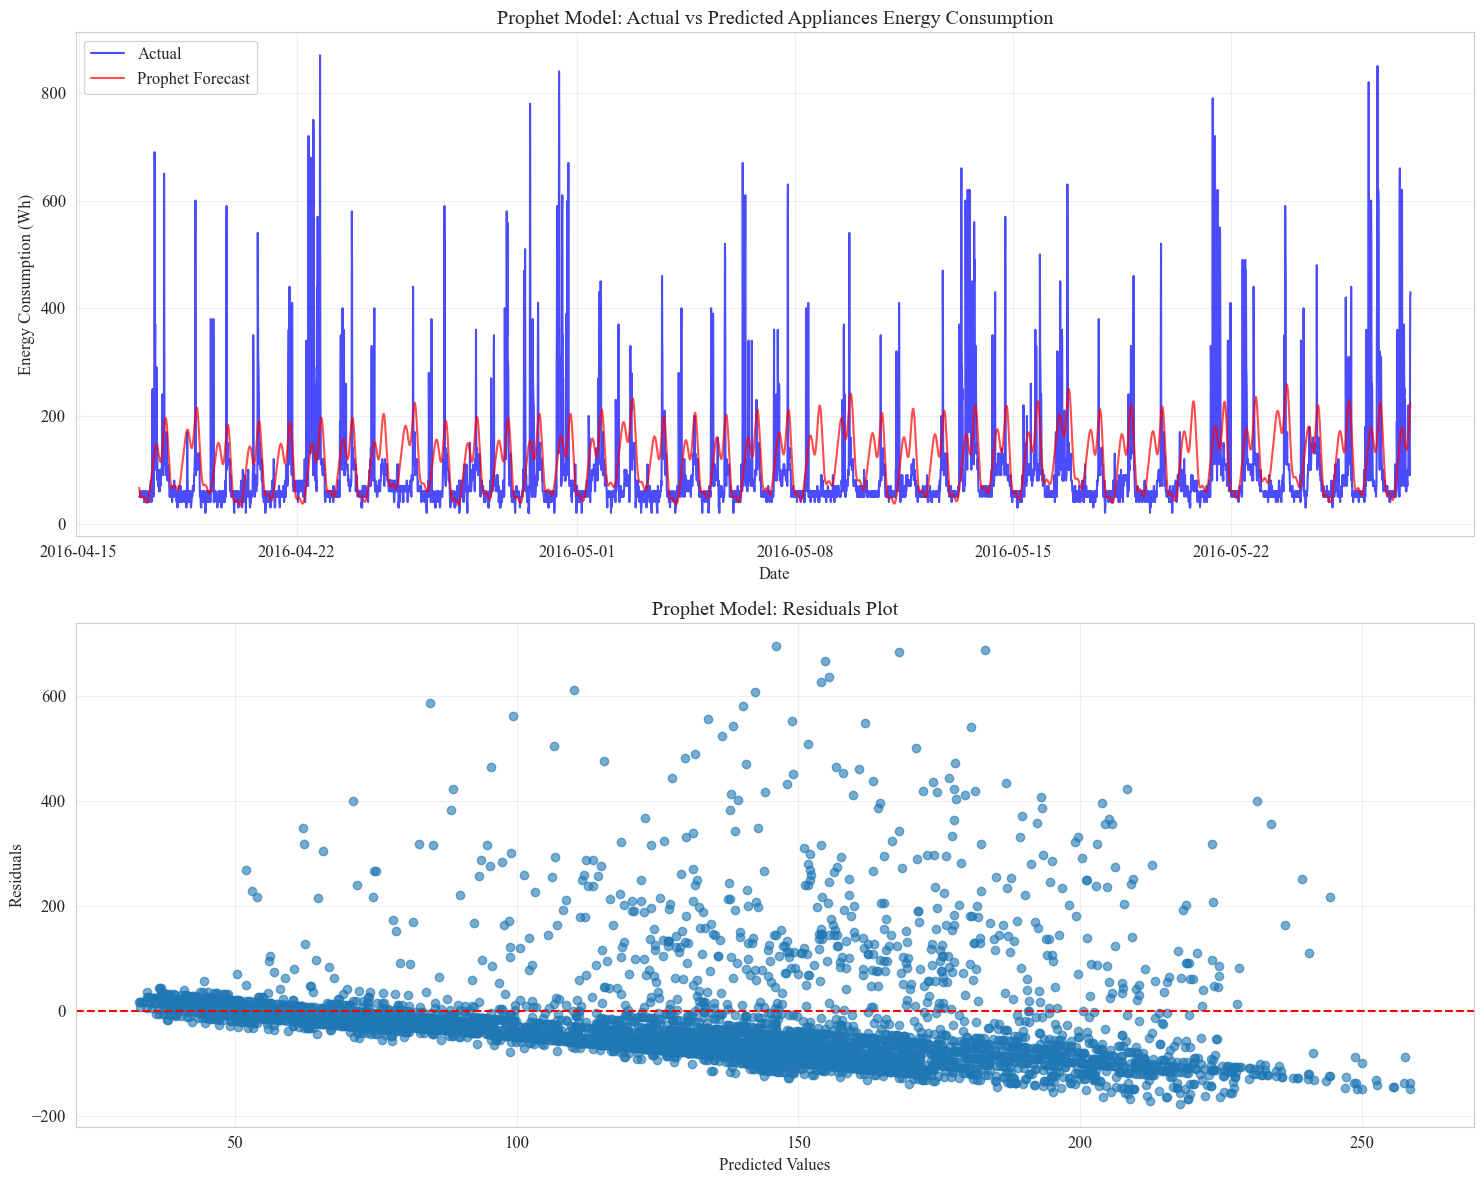

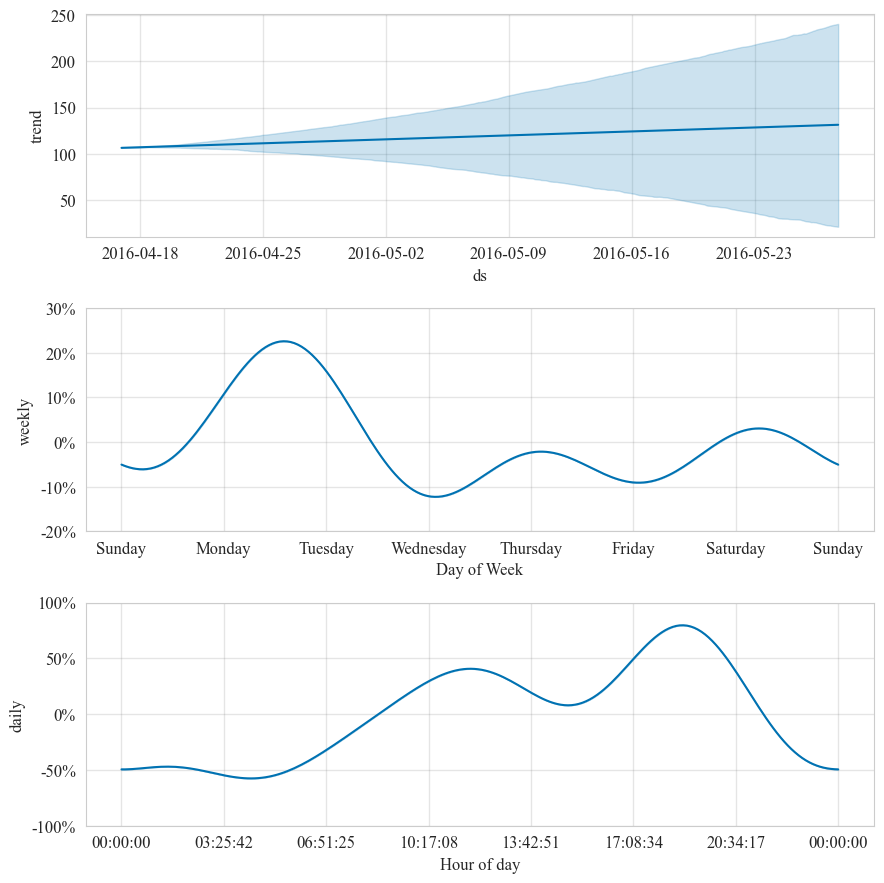

In [5]:
# Visualize Prophet results
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Forecast vs Actual
axes[0].plot(prophet_test['ds'], prophet_test['y'], label='Actual', color='blue', alpha=0.7)
axes[0].plot(prophet_test['ds'], prophet_predictions, label='Prophet Forecast', color='red', alpha=0.7)
axes[0].set_title('Prophet Model: Actual vs Predicted Appliances Energy Consumption')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Energy Consumption (Wh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals
residuals = prophet_test['y'].values - prophet_predictions
axes[1].scatter(prophet_predictions, residuals, alpha=0.6)
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_title('Prophet Model: Residuals Plot')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/prediction_plots/prophet_results.png', dpi=300, bbox_inches='tight')
plt.show()

# Prophet components
fig = prophet_model.plot_components(prophet_forecast)
plt.savefig('../results/prediction_plots/prophet_components.png', dpi=300, bbox_inches='tight')
plt.show()

## 2. ARIMA Model

In [6]:
# Check stationarity of the time series
def check_stationarity(timeseries, title):
    """Check if time series is stationary using Augmented Dickey-Fuller test"""
    print(f'Results of Augmented Dickey-Fuller Test for {title}:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    if dftest[1] <= 0.05:
        print("Series is stationary")
        return True
    else:
        print("Series is not stationary")
        return False

# Check original series
appliances_series = train_df[target]
is_stationary = check_stationarity(appliances_series, "Original Appliances Series")

# If not stationary, apply differencing
if not is_stationary:
    appliances_diff = appliances_series.diff().dropna()
    print("\nAfter first differencing:")
    is_stationary_diff = check_stationarity(appliances_diff, "First Differenced Series")
    
    if is_stationary_diff:
        d_param = 1
        working_series = appliances_diff
    else:
        appliances_diff2 = appliances_diff.diff().dropna()
        print("\nAfter second differencing:")
        check_stationarity(appliances_diff2, "Second Differenced Series")
        d_param = 2
        working_series = appliances_diff2
else:
    d_param = 0
    working_series = appliances_series

print(f"\nUsing d parameter: {d_param}")

Results of Augmented Dickey-Fuller Test for Original Appliances Series:


Test Statistic                -1.754582e+01
p-value                        4.166616e-30
#Lags Used                     1.300000e+01
Number of Observations Used    1.369900e+04
Critical Value (1%)           -3.430827e+00
Critical Value (5%)           -2.861751e+00
Critical Value (10%)          -2.566882e+00
dtype: float64
Series is stationary

Using d parameter: 0


In [7]:
print("Training ARIMA model...")

# Fit ARIMA model with auto-selected parameters
# Using a simple ARIMA(2,1,2) as a starting point
try:
    arima_model = ARIMA(train_df[target], order=(2, d_param, 2))
    arima_fitted = arima_model.fit()
    
    print("ARIMA model summary:")
    print(arima_fitted.summary())
    
    # Make predictions
    arima_forecast = arima_fitted.forecast(steps=len(test_df))
    arima_predictions = arima_forecast.values
    
    # Ensure predictions are non-negative (energy consumption can't be negative)
    arima_predictions = np.maximum(arima_predictions, 0)
    
    # Evaluate ARIMA model
    arima_results = evaluate_model(test_df[target].values, arima_predictions, 'ARIMA')
    
    print("ARIMA model training completed!")
    
except Exception as e:
    print(f"Error training ARIMA model: {e}")
    print("Trying simpler ARIMA(1,1,1) model...")
    
    try:
        arima_model = ARIMA(train_df[target], order=(1, 1, 1))
        arima_fitted = arima_model.fit()
        
        arima_forecast = arima_fitted.forecast(steps=len(test_df))
        arima_predictions = arima_forecast.values
        arima_predictions = np.maximum(arima_predictions, 0)
        
        arima_results = evaluate_model(test_df[target].values, arima_predictions, 'ARIMA')
        print("ARIMA(1,1,1) model training completed!")
        
    except Exception as e2:
        print(f"Error with ARIMA(1,1,1): {e2}")
        arima_predictions = np.full(len(test_df), train_df[target].mean())
        arima_results = evaluate_model(test_df[target].values, arima_predictions, 'ARIMA (Mean Baseline)')

Training ARIMA model...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 10min will be used.
  self._init_dates(dates, freq)


ARIMA model summary:
                               SARIMAX Results                                
Dep. Variable:             Appliances   No. Observations:                13713
Model:                 ARIMA(2, 0, 2)   Log Likelihood              -77350.790
Date:                Wed, 29 Oct 2025   AIC                         154713.581
Time:                        17:15:30   BIC                         154758.737
Sample:                    01-12-2016   HQIC                        154728.629
                         - 04-16-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.9602      7.978     12.404      0.000      83.324     114.597
ar.L1          1.3701      0.016     85.949      0.000       1.339       1.401
ar.L2         -0.3967      0.01

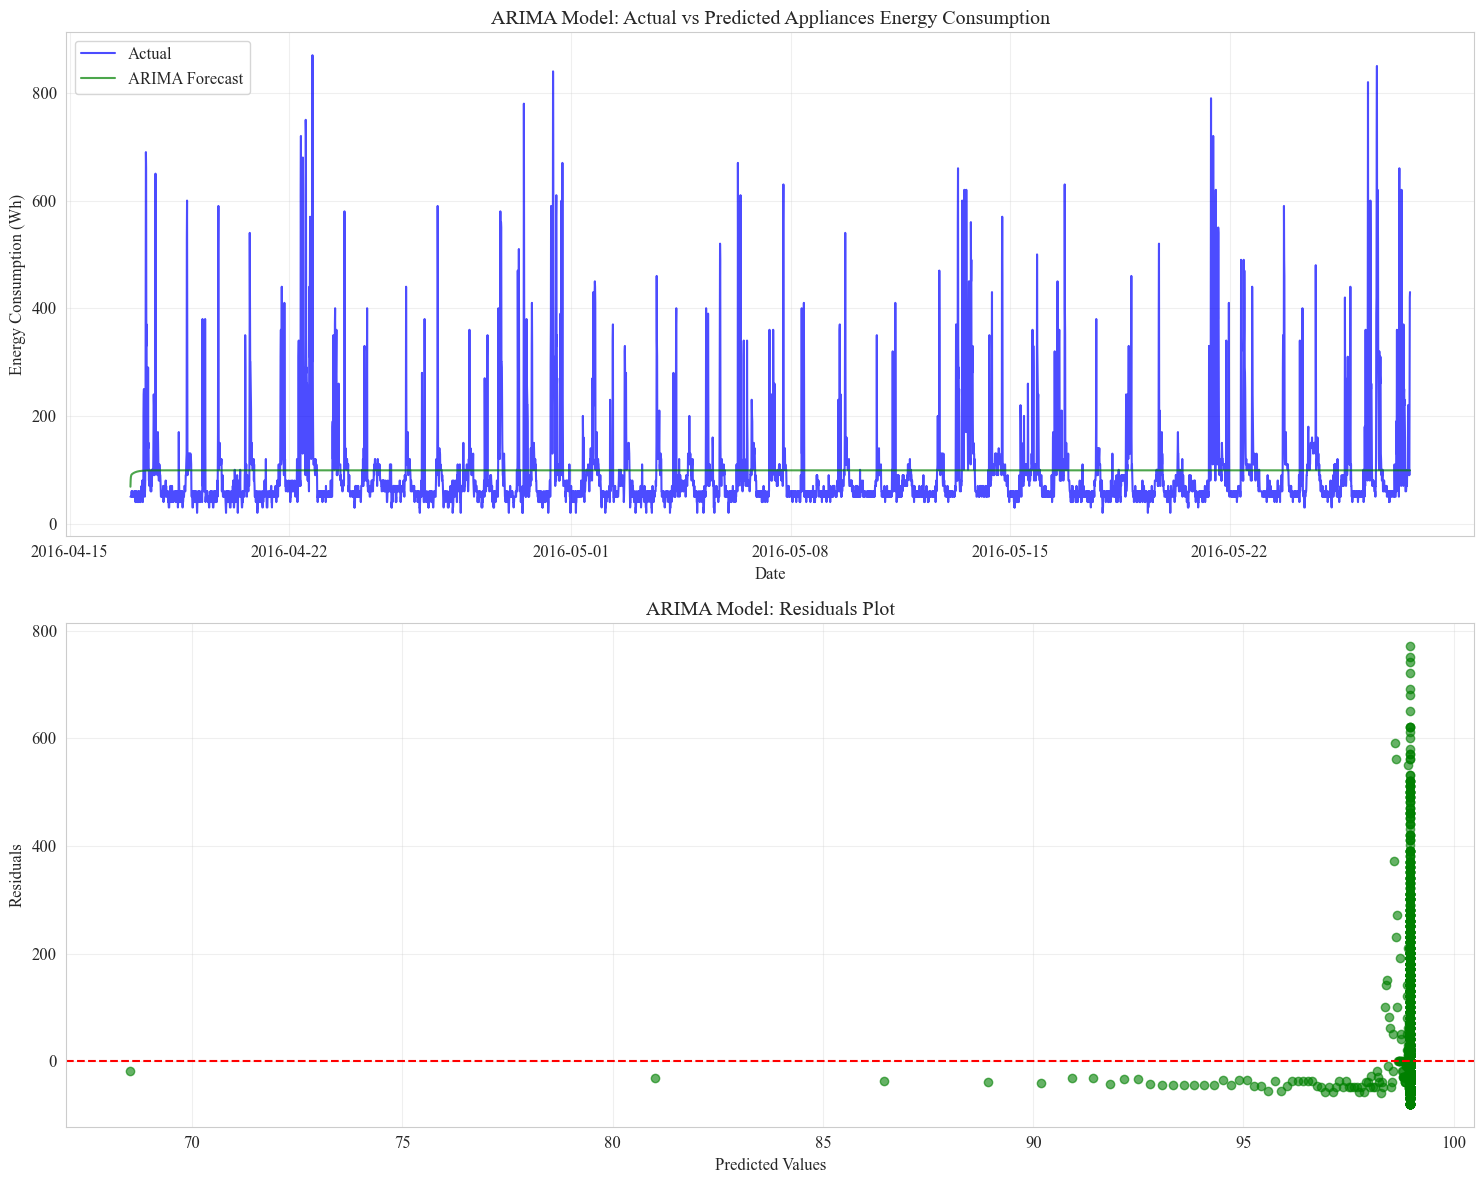

In [8]:
# Visualize ARIMA results
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Forecast vs Actual
axes[0].plot(test_df.index, test_df[target], label='Actual', color='blue', alpha=0.7)
axes[0].plot(test_df.index, arima_predictions, label='ARIMA Forecast', color='green', alpha=0.7)
axes[0].set_title('ARIMA Model: Actual vs Predicted Appliances Energy Consumption')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Energy Consumption (Wh)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals
arima_residuals = test_df[target].values - arima_predictions
axes[1].scatter(arima_predictions, arima_residuals, alpha=0.6, color='green')
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_title('ARIMA Model: Residuals Plot')
axes[1].set_xlabel('Predicted Values')
axes[1].set_ylabel('Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/prediction_plots/arima_results.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. LSTM Model

In [9]:
# Prepare data for LSTM
def create_lstm_dataset(data, target_col, features, lookback=24):
    """Create dataset for LSTM with lookback window"""
    # Scale the data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    X_scaled = scaler_X.fit_transform(data[features])
    y_scaled = scaler_y.fit_transform(data[target_col].values.reshape(-1, 1))
    
    X, y = [], []
    for i in range(lookback, len(X_scaled)):
        X.append(X_scaled[i-lookback:i])
        y.append(y_scaled[i])
    
    return np.array(X), np.array(y), scaler_X, scaler_y

print("Preparing LSTM data...")

# Use a subset of most important features for LSTM
lstm_features = ['lights', 'T_out', 'RH_out', 'hour_of_day', 'day_of_week', 
                 'is_weekend', 'Appliances_lag1', 'Appliances_rolling_mean_6']

lookback_window = 24  # Use 24 time steps (4 hours) to predict next step

# Prepare training data
X_train_lstm, y_train_lstm, scaler_X, scaler_y = create_lstm_dataset(
    train_df, target, lstm_features, lookback_window
)

print(f"LSTM training data shape: X={X_train_lstm.shape}, y={y_train_lstm.shape}")
print(f"Features used: {len(lstm_features)}")
print(f"Lookback window: {lookback_window} time steps")

Preparing LSTM data...
LSTM training data shape: X=(13689, 24, 8), y=(13689, 1)
Features used: 8
Lookback window: 24 time steps


In [10]:
print("Building and training LSTM model...")

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback_window, len(lstm_features))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

print("LSTM Model Architecture:")
lstm_model.summary()

# Train the model
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    verbose=1,
    shuffle=False  # Important for time series
)

print("LSTM model training completed!")

Building and training LSTM model...
LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,301 (130.08 KB)

 Trainable params: 33,301 (130.08 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 9:45 2s/step - loss: 0.0132 - mae: 0.0968

  7/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0260 - mae: 0.1240 

 14/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0302 - mae: 0.1358

 21/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0301 - mae: 0.1357

 28/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0296 - mae: 0.1330

 35/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0286 - mae: 0.1287

 42/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0276 - mae: 0.1246

 49/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0267 - mae: 0.1210

 56/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0261 - mae: 0.1186

 63/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0256 - mae: 0.1164

 70/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0250 - mae: 0.1142

 77/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0244 - mae: 0.1118

 85/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0237 - mae: 0.1093

 92/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0232 - mae: 0.1075

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0228 - mae: 0.1059

105/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0224 - mae: 0.1046

112/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0220 - mae: 0.1031

119/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0216 - mae: 0.1018

126/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0212 - mae: 0.1005

133/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0209 - mae: 0.0993

140/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0205 - mae: 0.0981

147/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0202 - mae: 0.0970

154/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0199 - mae: 0.0960

161/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0197 - mae: 0.0951

168/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0194 - mae: 0.0942

175/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0192 - mae: 0.0933

181/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0189 - mae: 0.0926

188/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0187 - mae: 0.0918

195/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0185 - mae: 0.0910

202/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0183 - mae: 0.0903

209/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0181 - mae: 0.0896

216/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0179 - mae: 0.0889

223/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0177 - mae: 0.0883

230/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175 - mae: 0.0877

237/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0174 - mae: 0.0871

244/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172 - mae: 0.0865

251/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0170 - mae: 0.0860

258/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0169 - mae: 0.0855

264/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0168 - mae: 0.0850

271/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0166 - mae: 0.0846

278/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0165 - mae: 0.0841

285/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0163 - mae: 0.0836

292/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0162 - mae: 0.0832

299/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0161 - mae: 0.0828

306/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0160 - mae: 0.0824

313/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0159 - mae: 0.0820

320/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0158 - mae: 0.0816

327/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0157 - mae: 0.0812

334/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0156 - mae: 0.0809

341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0155 - mae: 0.0805

343/343 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0108 - mae: 0.0643 - val_loss: 0.0081 - val_mae: 0.0459


Epoch 2/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 3.7037e-04 - mae: 0.0164

  7/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0045 - mae: 0.0382     

 13/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0091 - mae: 0.0516

 19/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0109 - mae: 0.0584

 25/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0122 - mae: 0.0631

 32/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0133 - mae: 0.0686

 38/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0137 - mae: 0.0713

 44/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0140 - mae: 0.0726

 51/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0140 - mae: 0.0730

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0141 - mae: 0.0732

 63/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0140 - mae: 0.0731

 70/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0139 - mae: 0.0729

 74/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0138 - mae: 0.0725

 79/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0137 - mae: 0.0720

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0136 - mae: 0.0714

 91/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0135 - mae: 0.0710

 97/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0134 - mae: 0.0707

104/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0133 - mae: 0.0703

110/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0132 - mae: 0.0700

117/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0130 - mae: 0.0696

124/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0129 - mae: 0.0693

130/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0129 - mae: 0.0690

136/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0128 - mae: 0.0687

142/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0127 - mae: 0.0685

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0126 - mae: 0.0682

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0125 - mae: 0.0680

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0125 - mae: 0.0677

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0124 - mae: 0.0674

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0123 - mae: 0.0672

182/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0122 - mae: 0.0670

188/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0122 - mae: 0.0668

195/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0121 - mae: 0.0665

202/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0120 - mae: 0.0663

209/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0119 - mae: 0.0660

215/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0119 - mae: 0.0658

221/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0118 - mae: 0.0656

227/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0117 - mae: 0.0654

233/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0117 - mae: 0.0652

239/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0116 - mae: 0.0650

245/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0116 - mae: 0.0648

251/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115 - mae: 0.0646

257/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115 - mae: 0.0645

263/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 - mae: 0.0643

269/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 - mae: 0.0641

275/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113 - mae: 0.0640

281/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0113 - mae: 0.0638

287/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mae: 0.0636

292/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0112 - mae: 0.0635

298/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.0634

304/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.0632

309/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0111 - mae: 0.0631

315/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110 - mae: 0.0630

321/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110 - mae: 0.0628

327/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 - mae: 0.0627

333/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 - mae: 0.0625

339/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 - mae: 0.0624

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0089 - mae: 0.0553 - val_loss: 0.0068 - val_mae: 0.0389


Epoch 3/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.0351e-04 - mae: 0.0135

  7/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0044 - mae: 0.0339     

 11/343 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0079 - mae: 0.0444

 17/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0100 - mae: 0.0517

 23/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0113 - mae: 0.0562

 28/343 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0120 - mae: 0.0596

 33/343 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0124 - mae: 0.0624

 38/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0126 - mae: 0.0641

 44/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0128 - mae: 0.0653

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0128 - mae: 0.0657

 56/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0129 - mae: 0.0660

 63/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0129 - mae: 0.0661

 70/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0128 - mae: 0.0660

 76/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0127 - mae: 0.0656 

 83/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0125 - mae: 0.0651

 90/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0124 - mae: 0.0648

 96/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0123 - mae: 0.0646

103/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0122 - mae: 0.0644

109/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0122 - mae: 0.0642

114/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0121 - mae: 0.0641

118/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0120 - mae: 0.0639

124/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0120 - mae: 0.0637

131/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0119 - mae: 0.0635

138/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0118 - mae: 0.0633

145/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0117 - mae: 0.0630

151/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0117 - mae: 0.0629

157/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0116 - mae: 0.0627

164/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0115 - mae: 0.0625

170/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0114 - mae: 0.0623

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0114 - mae: 0.0621

182/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0113 - mae: 0.0619

189/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0113 - mae: 0.0618

196/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0112 - mae: 0.0616

203/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0111 - mae: 0.0614

210/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0111 - mae: 0.0612

217/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0110 - mae: 0.0610

224/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0109 - mae: 0.0608

231/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0109 - mae: 0.0606

238/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0108 - mae: 0.0604

245/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0108 - mae: 0.0602

252/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0107 - mae: 0.0601

259/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106 - mae: 0.0599

265/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106 - mae: 0.0598

271/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0106 - mae: 0.0596

278/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - mae: 0.0595

285/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0105 - mae: 0.0593

292/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0104 - mae: 0.0592

299/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0104 - mae: 0.0591

305/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0103 - mae: 0.0590

312/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0103 - mae: 0.0588

319/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0103 - mae: 0.0587

326/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - mae: 0.0586

333/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - mae: 0.0584

340/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0102 - mae: 0.0583

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0084 - mae: 0.0527 - val_loss: 0.0066 - val_mae: 0.0387


Epoch 4/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.6855e-04 - mae: 0.0160

  7/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0041 - mae: 0.0341     

 14/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0089 - mae: 0.0484

 21/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0106 - mae: 0.0543

 28/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0116 - mae: 0.0590

 34/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0121 - mae: 0.0620

 41/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0124 - mae: 0.0640

 47/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0125 - mae: 0.0648

 53/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0125 - mae: 0.0650

 60/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0125 - mae: 0.0652

 66/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0125 - mae: 0.0652

 73/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0124 - mae: 0.0649

 80/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0122 - mae: 0.0643

 87/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0121 - mae: 0.0639

 94/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0120 - mae: 0.0636

101/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0119 - mae: 0.0633

108/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0118 - mae: 0.0631

115/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0117 - mae: 0.0628

122/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0116 - mae: 0.0625

129/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0115 - mae: 0.0623

136/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0115 - mae: 0.0620

143/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0114 - mae: 0.0618

150/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0113 - mae: 0.0616

157/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0112 - mae: 0.0614

164/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0112 - mae: 0.0612

171/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0111 - mae: 0.0609

178/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110 - mae: 0.0607

185/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0109 - mae: 0.0605

192/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0109 - mae: 0.0603

198/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - mae: 0.0601

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - mae: 0.0600

210/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0107 - mae: 0.0598

216/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0107 - mae: 0.0596

222/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0106 - mae: 0.0595

228/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0106 - mae: 0.0593

234/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0105 - mae: 0.0592

241/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0104 - mae: 0.0590

248/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0104 - mae: 0.0588

255/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - mae: 0.0586

262/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - mae: 0.0585

269/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0102 - mae: 0.0583

276/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0102 - mae: 0.0581

283/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0101 - mae: 0.0580

290/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0101 - mae: 0.0578

297/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0101 - mae: 0.0577

304/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - mae: 0.0576

311/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - mae: 0.0574

318/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - mae: 0.0573

325/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099 - mae: 0.0572

332/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099 - mae: 0.0570

339/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0098 - mae: 0.0569

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0082 - mae: 0.0515 - val_loss: 0.0065 - val_mae: 0.0385


Epoch 5/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.8587e-04 - mae: 0.0164

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0049 - mae: 0.0378     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0504

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0108 - mae: 0.0556

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0117 - mae: 0.0599

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0121 - mae: 0.0628

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0123 - mae: 0.0643

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0124 - mae: 0.0648

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0124 - mae: 0.0650

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0124 - mae: 0.0651

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0123 - mae: 0.0649

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0121 - mae: 0.0644

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0120 - mae: 0.0639

 92/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0119 - mae: 0.0636

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0118 - mae: 0.0634

106/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0117 - mae: 0.0631

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0116 - mae: 0.0629

119/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0115 - mae: 0.0626

125/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0114 - mae: 0.0624

128/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0114 - mae: 0.0622

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0113 - mae: 0.0620

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0113 - mae: 0.0618

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0112 - mae: 0.0615

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0111 - mae: 0.0613

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110 - mae: 0.0611

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110 - mae: 0.0608

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0109 - mae: 0.0606

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - mae: 0.0604

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - mae: 0.0602

197/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0107 - mae: 0.0600

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - mae: 0.0598

211/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - mae: 0.0595

218/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105 - mae: 0.0593

225/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0104 - mae: 0.0592

232/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0104 - mae: 0.0590

239/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - mae: 0.0588

245/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - mae: 0.0586

251/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0102 - mae: 0.0585

258/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0102 - mae: 0.0583

265/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0101 - mae: 0.0581

272/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0101 - mae: 0.0580

279/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - mae: 0.0578

286/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - mae: 0.0577

292/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - mae: 0.0575

298/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099 - mae: 0.0574

304/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099 - mae: 0.0573

310/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099 - mae: 0.0572

317/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0098 - mae: 0.0571

323/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0098 - mae: 0.0569

329/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0098 - mae: 0.0568

336/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097 - mae: 0.0567

343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097 - mae: 0.0566

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0081 - mae: 0.0509 - val_loss: 0.0065 - val_mae: 0.0381


Epoch 6/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.2539e-04 - mae: 0.0137

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0048 - mae: 0.0360     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0489

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0105 - mae: 0.0543

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0113 - mae: 0.0586

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0117 - mae: 0.0614

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0119 - mae: 0.0628

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0120 - mae: 0.0633

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0120 - mae: 0.0634

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0119 - mae: 0.0634

 70/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0119 - mae: 0.0633

 76/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0117 - mae: 0.0629

 82/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0116 - mae: 0.0624

 89/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0115 - mae: 0.0620

 95/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0114 - mae: 0.0617

101/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0113 - mae: 0.0615

107/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0113 - mae: 0.0613

114/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0112 - mae: 0.0610

121/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0111 - mae: 0.0607

128/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110 - mae: 0.0605

135/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0109 - mae: 0.0602

142/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - mae: 0.0600

149/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - mae: 0.0598

156/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0107 - mae: 0.0596

163/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - mae: 0.0593

170/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - mae: 0.0591

177/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105 - mae: 0.0589

184/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - mae: 0.0587

191/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - mae: 0.0585

198/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0103 - mae: 0.0583

205/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0103 - mae: 0.0581

212/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0102 - mae: 0.0579

219/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0101 - mae: 0.0577

226/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0101 - mae: 0.0575

233/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - mae: 0.0573

240/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - mae: 0.0572

247/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099 - mae: 0.0570

254/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099 - mae: 0.0568

261/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0098 - mae: 0.0567

268/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0098 - mae: 0.0565

275/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097 - mae: 0.0564

282/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097 - mae: 0.0562

289/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - mae: 0.0561

296/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - mae: 0.0560

303/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - mae: 0.0558

310/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095 - mae: 0.0557

317/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095 - mae: 0.0556

324/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095 - mae: 0.0555

331/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094 - mae: 0.0553

338/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094 - mae: 0.0552

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0079 - mae: 0.0499 - val_loss: 0.0063 - val_mae: 0.0373


Epoch 7/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.7219e-04 - mae: 0.0127

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0043 - mae: 0.0339     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0467

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0098 - mae: 0.0520

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0107 - mae: 0.0565

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0111 - mae: 0.0592

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0113 - mae: 0.0606

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0113 - mae: 0.0611

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0113 - mae: 0.0612

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0113 - mae: 0.0613

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0112 - mae: 0.0611

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0111 - mae: 0.0606

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0110 - mae: 0.0601

 92/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0109 - mae: 0.0598

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0108 - mae: 0.0595

106/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0107 - mae: 0.0593

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0107 - mae: 0.0590

120/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0106 - mae: 0.0587

127/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105 - mae: 0.0585

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - mae: 0.0582

140/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - mae: 0.0580

147/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0103 - mae: 0.0578

153/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0102 - mae: 0.0576

159/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0102 - mae: 0.0575

165/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0101 - mae: 0.0573

171/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0101 - mae: 0.0571

177/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - mae: 0.0569

184/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - mae: 0.0567

191/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - mae: 0.0565

198/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - mae: 0.0563

205/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0098 - mae: 0.0562

212/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0098 - mae: 0.0560

219/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097 - mae: 0.0558

226/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - mae: 0.0556

233/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - mae: 0.0555

240/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095 - mae: 0.0553

247/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095 - mae: 0.0551

254/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0095 - mae: 0.0550

261/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094 - mae: 0.0549

268/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094 - mae: 0.0547

275/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 - mae: 0.0546

282/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 - mae: 0.0544

289/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 - mae: 0.0543

295/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - mae: 0.0542

302/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - mae: 0.0541

309/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - mae: 0.0540

316/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091 - mae: 0.0539

322/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091 - mae: 0.0538

328/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091 - mae: 0.0537

335/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090 - mae: 0.0536

342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090 - mae: 0.0535

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0077 - mae: 0.0486 - val_loss: 0.0064 - val_mae: 0.0390


Epoch 8/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.2264e-04 - mae: 0.0149

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0044 - mae: 0.0356     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0480

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0531

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0104 - mae: 0.0571

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0107 - mae: 0.0594

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0109 - mae: 0.0606

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0110 - mae: 0.0609

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0110 - mae: 0.0611

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0110 - mae: 0.0611

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0109 - mae: 0.0609

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0107 - mae: 0.0603

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0106 - mae: 0.0597

 92/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0105 - mae: 0.0594

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0105 - mae: 0.0591

106/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0104 - mae: 0.0589

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0103 - mae: 0.0586

119/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0102 - mae: 0.0583

125/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0102 - mae: 0.0581

132/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0101 - mae: 0.0578

139/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - mae: 0.0575

146/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0100 - mae: 0.0573

153/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - mae: 0.0571

160/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - mae: 0.0569

167/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0098 - mae: 0.0566

174/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097 - mae: 0.0564

181/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097 - mae: 0.0562

188/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0096 - mae: 0.0560

195/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0096 - mae: 0.0558

202/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - mae: 0.0556

209/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0094 - mae: 0.0554

216/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0094 - mae: 0.0552

223/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 - mae: 0.0550

230/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 - mae: 0.0549

237/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - mae: 0.0547

244/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - mae: 0.0545

251/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0092 - mae: 0.0543

258/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091 - mae: 0.0542

265/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0091 - mae: 0.0540

271/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090 - mae: 0.0539

277/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090 - mae: 0.0538

283/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090 - mae: 0.0537

290/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0089 - mae: 0.0536

297/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0089 - mae: 0.0534

304/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0089 - mae: 0.0533

311/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0089 - mae: 0.0532

318/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 - mae: 0.0531

325/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 - mae: 0.0530

332/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 - mae: 0.0528

339/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087 - mae: 0.0527

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0074 - mae: 0.0477 - val_loss: 0.0065 - val_mae: 0.0406


Epoch 9/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.4532e-04 - mae: 0.0149

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0043 - mae: 0.0355     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0079 - mae: 0.0472

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0092 - mae: 0.0524

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0100 - mae: 0.0560

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0103 - mae: 0.0580

 42/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0104 - mae: 0.0588

 48/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0105 - mae: 0.0591

 54/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0105 - mae: 0.0592

 61/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0104 - mae: 0.0592

 68/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0104 - mae: 0.0590

 75/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0103 - mae: 0.0585

 82/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0101 - mae: 0.0579

 89/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0100 - mae: 0.0575

 96/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0100 - mae: 0.0572

103/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0099 - mae: 0.0569

109/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0098 - mae: 0.0567

115/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0098 - mae: 0.0565

122/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097 - mae: 0.0562

129/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0097 - mae: 0.0560

136/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0096 - mae: 0.0558

143/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - mae: 0.0556

150/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - mae: 0.0554

157/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0094 - mae: 0.0552

164/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0094 - mae: 0.0550

171/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - mae: 0.0548

178/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - mae: 0.0546

185/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - mae: 0.0544

192/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - mae: 0.0543

199/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0541

206/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0539

213/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0537

220/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090 - mae: 0.0536

227/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090 - mae: 0.0534

234/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0089 - mae: 0.0533

241/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0089 - mae: 0.0531

248/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 - mae: 0.0529

255/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 - mae: 0.0528

262/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 - mae: 0.0527

269/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087 - mae: 0.0525

276/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087 - mae: 0.0524

283/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087 - mae: 0.0523

290/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0086 - mae: 0.0522

297/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0086 - mae: 0.0521

304/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0086 - mae: 0.0520

311/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mae: 0.0519

318/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mae: 0.0517

325/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mae: 0.0516

332/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mae: 0.0515

339/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - mae: 0.0514

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0073 - mae: 0.0469 - val_loss: 0.0063 - val_mae: 0.0398


Epoch 10/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 5.4475e-04 - mae: 0.0185

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0041 - mae: 0.0359     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0074 - mae: 0.0469

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0517

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0095 - mae: 0.0551

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0098 - mae: 0.0568

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0099 - mae: 0.0576

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0100 - mae: 0.0578

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0100 - mae: 0.0578

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0100 - mae: 0.0577

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0099 - mae: 0.0574

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0098 - mae: 0.0569

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0097 - mae: 0.0563

 92/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0096 - mae: 0.0560

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - mae: 0.0557

106/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0095 - mae: 0.0555

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0094 - mae: 0.0552

120/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - mae: 0.0550

127/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - mae: 0.0547

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - mae: 0.0545

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - mae: 0.0543

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0542

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0540

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0538

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0536

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0535

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0533

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0532

197/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0530

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0528

211/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0527

218/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087 - mae: 0.0525

225/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0086 - mae: 0.0524

232/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0086 - mae: 0.0522

239/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0086 - mae: 0.0521

245/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mae: 0.0520

251/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mae: 0.0519

258/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mae: 0.0517

265/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - mae: 0.0516

272/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - mae: 0.0515

279/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - mae: 0.0514

286/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0513

293/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0512

300/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0511

307/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0510

314/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0509

321/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0508

325/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0507

331/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0506

337/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0506

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0071 - mae: 0.0464 - val_loss: 0.0064 - val_mae: 0.0404


Epoch 11/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 5.4788e-04 - mae: 0.0194

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0040 - mae: 0.0360     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0072 - mae: 0.0468

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - mae: 0.0516

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0092 - mae: 0.0550

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0095 - mae: 0.0567

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0097 - mae: 0.0576

 47/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0098 - mae: 0.0577

 51/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0097 - mae: 0.0577

 56/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0098 - mae: 0.0578

 62/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0097 - mae: 0.0577

 68/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0097 - mae: 0.0575

 74/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0096 - mae: 0.0571

 81/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0095 - mae: 0.0565

 88/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0094 - mae: 0.0561

 94/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0093 - mae: 0.0558

101/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0093 - mae: 0.0556

107/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0092 - mae: 0.0554

114/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0092 - mae: 0.0551

121/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0091 - mae: 0.0548

128/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0091 - mae: 0.0546

135/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0090 - mae: 0.0544

142/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0090 - mae: 0.0542

149/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0089 - mae: 0.0540

156/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0089 - mae: 0.0538

163/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0088 - mae: 0.0536

170/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0088 - mae: 0.0534

177/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0087 - mae: 0.0533

184/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0087 - mae: 0.0531

191/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0087 - mae: 0.0530

198/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0528

205/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0526

212/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0525

219/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0523

226/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mae: 0.0522

233/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - mae: 0.0520

240/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - mae: 0.0519

246/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - mae: 0.0517

253/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0516

260/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0515

267/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0514

274/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0512

281/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0511

286/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0510

290/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0510

296/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0509

302/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0508

309/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0507

316/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0506

323/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0505

329/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0504

336/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0503

343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0502

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0070 - mae: 0.0460 - val_loss: 0.0062 - val_mae: 0.0394


Epoch 12/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 4.7536e-04 - mae: 0.0174

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0039 - mae: 0.0359     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0071 - mae: 0.0469

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - mae: 0.0520

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0555

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0572

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0098 - mae: 0.0581

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0098 - mae: 0.0582

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0099 - mae: 0.0582

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0098 - mae: 0.0581

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0097 - mae: 0.0578

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0572

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0095 - mae: 0.0566

 91/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0563

 98/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0094 - mae: 0.0560

105/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - mae: 0.0557

112/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - mae: 0.0555

119/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - mae: 0.0551

126/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - mae: 0.0549

133/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0546

140/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0544

147/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0541

154/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0539

160/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0537

167/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0535

174/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0533

181/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0531

187/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0529

194/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0528

201/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0526

207/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0524

213/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0523

220/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mae: 0.0521

227/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mae: 0.0519

233/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0085 - mae: 0.0518

240/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - mae: 0.0516

247/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - mae: 0.0515

254/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0513

261/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0512

268/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0510

275/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0509

282/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0508

289/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0507

296/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0505

303/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0504

310/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0503

317/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0502

324/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0501

331/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0500

338/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0499

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0069 - mae: 0.0454 - val_loss: 0.0062 - val_mae: 0.0396


Epoch 13/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 5.6712e-04 - mae: 0.0195

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0041 - mae: 0.0367     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0074 - mae: 0.0476

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0524

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0557

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0572

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0098 - mae: 0.0580

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0098 - mae: 0.0581

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0098 - mae: 0.0580

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0097 - mae: 0.0578

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0097 - mae: 0.0575

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0095 - mae: 0.0569

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0563

 92/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - mae: 0.0559

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0093 - mae: 0.0556

106/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - mae: 0.0553

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0550

120/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0547

127/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0544

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0542

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0540

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0538

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0535

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0534

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0531

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0529

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0528

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0526

197/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0524

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0522

211/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0521

218/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - mae: 0.0519

225/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - mae: 0.0517

232/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - mae: 0.0516

239/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0514

246/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0512

253/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0511

260/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0510

267/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0508

274/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0507

281/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0506

288/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0505

295/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0504

302/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0503

309/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0502

316/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0501

323/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0499

330/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0498

337/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0497

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0069 - mae: 0.0454 - val_loss: 0.0062 - val_mae: 0.0391


Epoch 14/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.0459e-04 - mae: 0.0142

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0039 - mae: 0.0341     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0072 - mae: 0.0451

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - mae: 0.0500

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0533

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0549

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0559

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0561

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0562

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0561

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0095 - mae: 0.0559

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0554

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0549

 92/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - mae: 0.0546

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - mae: 0.0544

106/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0542

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0539

120/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0536

127/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0534

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0532

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0530

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0528

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0526

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0525

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0523

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0521

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0520

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0518

197/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0516

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0515

211/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0513

218/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - mae: 0.0512

225/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0510

232/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0509

239/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0507

246/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0506

253/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0505

260/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0504

267/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0502

274/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0501

281/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0500

288/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0499

295/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0498

302/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0497

309/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0496

316/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0495

323/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0494

330/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0493

337/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0493

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0069 - mae: 0.0454 - val_loss: 0.0061 - val_mae: 0.0377


Epoch 15/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.7749e-04 - mae: 0.0155

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0039 - mae: 0.0346     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0071 - mae: 0.0457

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0502

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0534

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0550

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0095 - mae: 0.0560

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0562

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0563

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0562

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0095 - mae: 0.0560

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0555

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0550

 92/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - mae: 0.0547

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - mae: 0.0545

106/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0543

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0540

120/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0537

127/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0535

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0533

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0531

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0529

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0527

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0525

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0523

175/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0522

181/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0520

188/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0519

195/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0517

202/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0515

209/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0514

216/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0512

223/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0511

230/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0509

237/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0508

244/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0506

251/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0505

258/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0503

265/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0502

271/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0501

278/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0500

285/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0499

292/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0498

299/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0497

306/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0496

313/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0495

320/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0494

327/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0493

334/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0492

341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0491

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0069 - mae: 0.0451 - val_loss: 0.0061 - val_mae: 0.0379


Epoch 16/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 4.5188e-04 - mae: 0.0176

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0039 - mae: 0.0352     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0073 - mae: 0.0457

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0506

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0539

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0555

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0097 - mae: 0.0563

 49/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0098 - mae: 0.0565

 55/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0097 - mae: 0.0566

 58/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0097 - mae: 0.0565

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0097 - mae: 0.0565

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0096 - mae: 0.0562

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0095 - mae: 0.0556

 84/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0094 - mae: 0.0552

 91/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0548

 98/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0546

105/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0092 - mae: 0.0543

111/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0541

118/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0538

125/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0536

132/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0533

139/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0531

146/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0529

152/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0527

159/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0526

166/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0524

173/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0522

179/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0520

185/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0519

191/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0517

198/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0516

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0514

211/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0513

218/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0511

225/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0509

231/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0508

238/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0507

244/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0505

251/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0504

258/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0503

264/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0502

270/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0501

277/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0499

284/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0498

291/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0497

297/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0496

303/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0495

308/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0495

311/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0494

317/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0493

324/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0492

330/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0491

336/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0491

342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0490

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0068 - mae: 0.0449 - val_loss: 0.0060 - val_mae: 0.0379


Epoch 17/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 4.2886e-04 - mae: 0.0163

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0037 - mae: 0.0345     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0069 - mae: 0.0450

 21/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0080 - mae: 0.0491

 27/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0522

 33/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0540

 40/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0551

 47/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0556

 53/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0557

 60/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0557

 66/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0556

 72/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0553

 79/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0547

 86/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0543

 93/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0540

100/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0089 - mae: 0.0537

107/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0535

114/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0533

121/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0530

128/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0528

135/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0526

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0524

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0523

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0521

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0519

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0517

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0516

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0514

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0513

197/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0511

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0510

211/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0508

218/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0507

225/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0505

232/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0504

239/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0502

246/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0501

253/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0500

259/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0499

266/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0498

273/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0496

280/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0495

287/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0494

294/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0493

301/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0492

308/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0491

315/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0490

322/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0489

329/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0488

336/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0487

343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0486

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0067 - mae: 0.0447 - val_loss: 0.0060 - val_mae: 0.0381


Epoch 18/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.8472e-04 - mae: 0.0159

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0039 - mae: 0.0351     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0071 - mae: 0.0461

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - mae: 0.0508

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0538

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0553

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0561

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0562

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0562

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0560

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0095 - mae: 0.0557

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0552

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0092 - mae: 0.0547

 92/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0092 - mae: 0.0543

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0541

106/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0538

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0536

120/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0533

127/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0531

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0528

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0526

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0525

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0523

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0521

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0519

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0518

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0516

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0514

197/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0513

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0511

211/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0510

218/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - mae: 0.0508

225/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0507

232/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0505

239/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0504

246/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0502

253/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0501

260/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0500

267/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0499

274/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0497

281/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0496

288/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0495

295/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0494

302/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0493

309/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0492

316/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0491

323/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0490

330/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0489

337/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0488

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0068 - mae: 0.0446 - val_loss: 0.0059 - val_mae: 0.0365


Epoch 19/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.7692e-04 - mae: 0.0153

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0039 - mae: 0.0352     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0071 - mae: 0.0458

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0505

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0537

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0092 - mae: 0.0551

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0558

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0559

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0559

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0557

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0554

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0549

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0544

 92/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0540

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0538

106/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0536

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0533

120/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0530

127/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0528

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0526

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0524

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0522

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0520

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0518

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0516

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0514

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0513

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0511

197/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0510

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0508

211/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0506

218/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0505

225/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0503

232/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0502

239/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0500

246/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0499

253/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0498

260/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0496

267/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0495

274/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0494

281/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0493

288/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0492

295/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0491

302/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0490

309/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0489

316/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0488

323/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0487

330/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0486

337/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0485

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0067 - mae: 0.0444 - val_loss: 0.0058 - val_mae: 0.0364


Epoch 20/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.7694e-04 - mae: 0.0159

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0039 - mae: 0.0358     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0071 - mae: 0.0466

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0515

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0546

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0558

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0564

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0564

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0563

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0561

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0558

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0552

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0546

 92/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0543

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0540

106/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0538

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0535

120/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0532

127/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0529

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0527

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0525

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0523

154/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0521

160/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0520

167/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0518

174/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0516

181/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0514

188/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0512

195/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0510

202/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0509

209/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0507

216/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0506

223/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0504

230/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0503

237/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0501

244/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0499

251/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0498

258/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0497

265/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0495

272/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0494

279/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0493

286/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0492

293/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0491

300/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0490

307/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0489

314/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0488

321/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0487

328/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0486

335/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0485

342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0484

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0067 - mae: 0.0443 - val_loss: 0.0058 - val_mae: 0.0364


Epoch 21/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.6073e-04 - mae: 0.0152

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0041 - mae: 0.0346     

 14/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0071 - mae: 0.0444

 21/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0494

 27/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0526

 34/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0545

 41/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0095 - mae: 0.0554

 48/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0557

 55/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0556

 62/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0555

 69/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0095 - mae: 0.0552

 76/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0547

 83/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0092 - mae: 0.0542

 90/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0092 - mae: 0.0538

 97/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0091 - mae: 0.0535

104/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0533

110/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0531

116/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0529

123/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0526

129/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0524

135/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0522

142/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0520

149/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0518

156/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0516

163/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0515

170/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0513

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0511

181/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0510

187/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0508

193/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0507

199/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0506

206/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0504

213/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0502

220/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0501

227/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0082 - mae: 0.0499

233/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0498

239/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0497

245/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0496

251/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0494

257/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0493

263/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0492

269/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0491

275/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0490

281/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0489

287/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0488

290/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0488

295/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0487

301/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0486

307/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0485

313/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0484

320/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0483

327/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0482

334/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0481

341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0480

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0067 - mae: 0.0440 - val_loss: 0.0058 - val_mae: 0.0373


Epoch 22/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 4.0497e-04 - mae: 0.0165

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0041 - mae: 0.0350     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0071 - mae: 0.0452

 21/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0081 - mae: 0.0493

 27/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0089 - mae: 0.0525

 33/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0092 - mae: 0.0541

 39/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0094 - mae: 0.0549

 46/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0095 - mae: 0.0554

 52/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0095 - mae: 0.0553

 59/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0094 - mae: 0.0553

 66/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0094 - mae: 0.0551

 73/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0548

 80/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0092 - mae: 0.0542

 87/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0538

 94/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0535

101/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0532

108/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0530

115/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0527

122/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0525

129/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0523

136/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0520

143/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0518

150/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0517

157/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0515

164/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0513

171/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0511

178/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0510

185/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0508

192/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0506

199/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0505

206/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0503

213/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0502

220/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0500

227/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0499

234/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0497

241/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0496

248/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0495

255/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0493

262/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0492

268/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0491

275/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0490

281/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0489

287/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0488

293/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0487

300/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0486

307/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0485

314/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0484

321/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0483

328/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0482

335/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0481

342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0480

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0067 - mae: 0.0440 - val_loss: 0.0057 - val_mae: 0.0364


Epoch 23/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 4.0183e-04 - mae: 0.0162

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0040 - mae: 0.0344     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0073 - mae: 0.0451

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0498

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0092 - mae: 0.0530

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0095 - mae: 0.0545

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0552

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0553

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0096 - mae: 0.0553

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0095 - mae: 0.0551

 70/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0548

 76/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0544

 82/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0092 - mae: 0.0539

 89/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0535

 96/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0533

103/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0090 - mae: 0.0530

110/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0528

117/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0525

124/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0523

131/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0521

138/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0518

145/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0517

152/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0515

158/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0513

164/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0512

171/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0510

178/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0508

185/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0507

192/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0505

199/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0504

206/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0502

212/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0501

219/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0499

226/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0498

233/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0496

240/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0081 - mae: 0.0495

246/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0494

253/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0493

259/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0491

265/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0490

272/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0489

279/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0488

286/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0487

292/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0486

299/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0485

306/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0484

313/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0483

320/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0482

327/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0481

334/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0480

341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0479

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0067 - mae: 0.0439 - val_loss: 0.0057 - val_mae: 0.0366


Epoch 24/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.2390e-04 - mae: 0.0153

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0040 - mae: 0.0351     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0072 - mae: 0.0457

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - mae: 0.0503

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0534

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0547

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0554

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0555

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0554

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0552

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0549

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0543

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0538

 92/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0534

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0531

106/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0529

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0526

120/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0523

127/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0521

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0519

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0517

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0515

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0513

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0511

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0509

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0507

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0506

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0504

197/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0502

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0501

211/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0499

218/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0498

225/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0496

231/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0495

237/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0494

243/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0493

249/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0491

255/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0490

262/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0489

269/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0488

275/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0487

282/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0486

289/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0485

296/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0484

302/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0483

308/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0482

314/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0481

321/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0480

328/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0479

335/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0478

342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0477

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0066 - mae: 0.0437 - val_loss: 0.0057 - val_mae: 0.0364


Epoch 25/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.8983e-04 - mae: 0.0148

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0040 - mae: 0.0350     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0071 - mae: 0.0457

 21/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0496

 28/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0529

 35/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0092 - mae: 0.0542

 42/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0549

 49/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0550

 56/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0094 - mae: 0.0549

 63/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0547

 70/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0545

 77/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0540

 83/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0535

 89/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0532

 95/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0089 - mae: 0.0530

102/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - mae: 0.0527

109/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0088 - mae: 0.0525

116/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0523

123/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0520

130/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0518

137/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0516

144/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0514

151/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0512

157/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0511

163/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0510

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0508

175/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0507

181/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0505

187/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0504

193/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0503

199/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0501

206/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0500

213/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0498

220/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0497

226/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0496

233/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0494

239/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0493

246/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0491

253/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0490

260/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0079 - mae: 0.0489

267/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0488

274/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0487

280/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0486

286/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0485

293/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0484

300/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0483

307/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0482

314/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0481

321/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0480

328/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0479

335/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0478

342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0477

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0066 - mae: 0.0437 - val_loss: 0.0057 - val_mae: 0.0367


Epoch 26/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 2.6639e-04 - mae: 0.0127

  6/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0029 - mae: 0.0297    

 10/343 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0054 - mae: 0.0390

 16/343 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0073 - mae: 0.0458

 23/343 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0085 - mae: 0.0504

 29/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0091 - mae: 0.0529

 35/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0093 - mae: 0.0541

 41/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0094 - mae: 0.0548

 47/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0094 - mae: 0.0551

 53/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0094 - mae: 0.0550

 59/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0094 - mae: 0.0549

 65/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0093 - mae: 0.0547

 72/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0092 - mae: 0.0544 

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0091 - mae: 0.0539

 84/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0090 - mae: 0.0534

 90/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0089 - mae: 0.0531

 96/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0089 - mae: 0.0529

102/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0088 - mae: 0.0527

107/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0088 - mae: 0.0525

113/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0087 - mae: 0.0523

119/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0087 - mae: 0.0520

125/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0086 - mae: 0.0518

131/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0086 - mae: 0.0516

137/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0085 - mae: 0.0514

143/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0085 - mae: 0.0513

149/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084 - mae: 0.0511

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084 - mae: 0.0510

161/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084 - mae: 0.0508

167/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0083 - mae: 0.0507

173/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0083 - mae: 0.0505

179/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mae: 0.0503

184/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mae: 0.0502

187/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mae: 0.0502

192/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mae: 0.0500

198/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081 - mae: 0.0499

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081 - mae: 0.0498

208/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081 - mae: 0.0497

214/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - mae: 0.0495

220/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - mae: 0.0494

226/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - mae: 0.0493

231/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mae: 0.0492

237/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0491

243/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0489

249/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0488

255/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0487

261/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0486

268/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0485

274/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0484

280/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0483

286/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0482

292/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0481

298/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0480

304/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0479

310/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0478

317/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0478

324/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0476

331/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0476

338/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0475

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0066 - mae: 0.0434 - val_loss: 0.0057 - val_mae: 0.0362


Epoch 27/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 3.9371e-04 - mae: 0.0161

  7/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0033 - mae: 0.0327     

 13/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0065 - mae: 0.0435

 19/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0077 - mae: 0.0482

 25/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0086 - mae: 0.0515

 30/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0089 - mae: 0.0530

 33/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0090 - mae: 0.0535

 37/343 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0091 - mae: 0.0541

 43/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0093 - mae: 0.0546

 49/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0093 - mae: 0.0546

 55/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0093 - mae: 0.0546

 61/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0092 - mae: 0.0545

 68/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0092 - mae: 0.0542

 74/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0091 - mae: 0.0539

 80/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0090 - mae: 0.0533

 86/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0089 - mae: 0.0529

 92/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0088 - mae: 0.0526 

 98/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0088 - mae: 0.0524

104/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0087 - mae: 0.0522

110/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0087 - mae: 0.0520

117/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0086 - mae: 0.0517

123/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0085 - mae: 0.0515

129/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0085 - mae: 0.0513

135/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0085 - mae: 0.0511

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084 - mae: 0.0510

147/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084 - mae: 0.0508

153/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0083 - mae: 0.0507

159/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0083 - mae: 0.0505

165/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0083 - mae: 0.0504

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mae: 0.0503

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mae: 0.0501

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081 - mae: 0.0499

189/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081 - mae: 0.0498

195/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081 - mae: 0.0497

201/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - mae: 0.0495

207/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - mae: 0.0494

213/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - mae: 0.0493

219/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mae: 0.0492

225/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mae: 0.0490

231/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mae: 0.0489

237/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0488

243/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0487

250/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0485

256/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0484

262/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0483

268/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0482

274/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0481

280/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0480

286/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0479

292/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0478

299/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0477

306/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0476

313/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0475

320/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0475

327/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0473

334/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0473

341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0472

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0065 - mae: 0.0431 - val_loss: 0.0057 - val_mae: 0.0359


Epoch 28/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 2.6862e-04 - mae: 0.0134

  7/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0032 - mae: 0.0310     

 13/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0064 - mae: 0.0422

 19/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0077 - mae: 0.0474

 25/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0086 - mae: 0.0508

 31/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0090 - mae: 0.0526

 37/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0092 - mae: 0.0535

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0093 - mae: 0.0540

 49/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0093 - mae: 0.0541

 55/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0093 - mae: 0.0540

 61/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0093 - mae: 0.0539

 67/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0092 - mae: 0.0537

 73/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0091 - mae: 0.0534

 79/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0090 - mae: 0.0529

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0089 - mae: 0.0526

 91/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0089 - mae: 0.0523

 98/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0088 - mae: 0.0520

104/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0087 - mae: 0.0519

110/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0087 - mae: 0.0517

116/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0086 - mae: 0.0515

122/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0086 - mae: 0.0513

129/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0085 - mae: 0.0511

135/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0085 - mae: 0.0509

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084 - mae: 0.0507

147/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084 - mae: 0.0506

154/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0083 - mae: 0.0504

160/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0083 - mae: 0.0503

166/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0083 - mae: 0.0501

172/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mae: 0.0500

179/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mae: 0.0498

184/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mae: 0.0497

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081 - mae: 0.0496

196/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081 - mae: 0.0494

202/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - mae: 0.0493

208/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - mae: 0.0492

214/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - mae: 0.0491

219/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - mae: 0.0490

224/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mae: 0.0489

230/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0488

236/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0487

242/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0485

248/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0484

254/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0483

260/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0482

267/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0481

273/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0480

279/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0479

285/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0478

291/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0477

297/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0476

303/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0476

309/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0475

315/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0474

321/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0473

327/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0472

333/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0472

339/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0471

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0065 - mae: 0.0432 - val_loss: 0.0057 - val_mae: 0.0363


Epoch 29/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.1073e-04 - mae: 0.0139

  7/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0032 - mae: 0.0313     

 14/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0068 - mae: 0.0435

 21/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0081 - mae: 0.0485

 28/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0089 - mae: 0.0519

 35/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0531

 41/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0537

 47/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0539

 53/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0093 - mae: 0.0539

 60/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0092 - mae: 0.0538

 67/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0092 - mae: 0.0537

 74/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0533

 81/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0089 - mae: 0.0528

 88/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0523

 95/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0521

102/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0519

109/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - mae: 0.0517

116/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0514

122/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0512

128/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0510

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0509

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0507

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0505

154/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0503

160/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0502

166/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0501

172/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0499

179/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0498

185/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0496

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0495

196/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0494

202/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0493

208/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0491

214/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0490

220/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mae: 0.0489

226/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0488

232/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0486

238/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0485

244/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0484

251/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0483

258/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0481

265/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0480

272/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0479

279/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0478

286/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0477

293/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0476

298/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0475

304/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0474

307/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0474

312/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0473

317/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0472

322/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0472

328/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0471

334/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mae: 0.0470

340/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mae: 0.0469

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0065 - mae: 0.0429 - val_loss: 0.0056 - val_mae: 0.0352


Epoch 30/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 2.6501e-04 - mae: 0.0135

  7/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0032 - mae: 0.0316     

 13/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0063 - mae: 0.0423

 19/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0076 - mae: 0.0474

 26/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0085 - mae: 0.0512

 32/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0089 - mae: 0.0527

 38/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0090 - mae: 0.0535

 44/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0091 - mae: 0.0539

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0091 - mae: 0.0539

 56/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0091 - mae: 0.0539

 63/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0091 - mae: 0.0537

 69/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0090 - mae: 0.0535

 76/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0089 - mae: 0.0531

 83/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0525

 90/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0522

 97/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0519

103/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0517

110/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0515

116/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0513

123/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0510

129/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0509

135/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0507

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0505

147/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0503

153/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0502

159/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0501

166/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0499

172/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0498

179/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0496

186/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0495

192/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0493

199/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0492

206/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0491

213/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0489

220/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0488

227/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0486

234/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0485

241/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0484

248/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0482

255/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0481

262/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0480

269/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0479

276/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0478

283/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0477

290/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0476

297/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0475

304/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0474

310/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0473

317/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0472

324/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0471

331/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0470

338/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0469

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0065 - mae: 0.0431 - val_loss: 0.0056 - val_mae: 0.0356


Epoch 31/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.2271e-04 - mae: 0.0147

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0038 - mae: 0.0337     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0069 - mae: 0.0444

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0081 - mae: 0.0490

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0518

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0528

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0534

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0534

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0534

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0533

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0089 - mae: 0.0531

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0526

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0522

 92/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0519

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0086 - mae: 0.0517

106/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0515

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0513

120/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0511

127/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0509

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0506

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0505

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0503

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0501

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0500

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0498

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0497

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0495

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0494

197/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0492

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0491

207/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0490

212/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0489

218/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0488

224/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0487

231/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 - mae: 0.0485

237/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0484

244/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0483

250/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0482

256/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0481

262/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0480

268/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0479

274/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0478

280/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0477

286/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0476

292/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0475

299/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0474

306/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0473

312/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0472

319/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0471

325/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0470

332/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0470

339/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0469

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0065 - mae: 0.0429 - val_loss: 0.0057 - val_mae: 0.0365


Epoch 32/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.1603e-04 - mae: 0.0114

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0039 - mae: 0.0333     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0069 - mae: 0.0441

 20/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0078 - mae: 0.0477

 26/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0086 - mae: 0.0509

 32/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0089 - mae: 0.0523

 35/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0090 - mae: 0.0527

 41/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0091 - mae: 0.0533

 47/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0091 - mae: 0.0534

 53/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0091 - mae: 0.0534

 60/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0091 - mae: 0.0533 

 67/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0090 - mae: 0.0532

 73/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0089 - mae: 0.0529

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0088 - mae: 0.0525

 84/343 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0087 - mae: 0.0522

 90/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0087 - mae: 0.0519 

 96/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0086 - mae: 0.0517

103/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0086 - mae: 0.0515

109/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0085 - mae: 0.0513

116/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0085 - mae: 0.0511

123/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0084 - mae: 0.0509

129/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084 - mae: 0.0507

136/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0083 - mae: 0.0505

143/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0083 - mae: 0.0504

149/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mae: 0.0502

156/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mae: 0.0501

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081 - mae: 0.0500

168/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081 - mae: 0.0498

174/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081 - mae: 0.0497

181/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - mae: 0.0495

187/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - mae: 0.0494

193/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - mae: 0.0493

199/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mae: 0.0492

205/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mae: 0.0490

211/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mae: 0.0489

216/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0078 - mae: 0.0488

222/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0078 - mae: 0.0487

228/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0078 - mae: 0.0486

234/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0485

241/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0483

247/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0482

254/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0481

260/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0480

267/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0479

274/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0478

281/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0477

288/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0475

295/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0475

302/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0474

309/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mae: 0.0473

316/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mae: 0.0472

322/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mae: 0.0471

329/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mae: 0.0470

336/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0074 - mae: 0.0469

343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0073 - mae: 0.0468

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0064 - mae: 0.0428 - val_loss: 0.0057 - val_mae: 0.0362


Epoch 33/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.8143e-04 - mae: 0.0153

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0038 - mae: 0.0339     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0069 - mae: 0.0446

 21/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0079 - mae: 0.0485

 28/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0516

 34/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0089 - mae: 0.0524

 40/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0530

 47/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0532

 53/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0532

 60/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0531

 66/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0530

 73/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0089 - mae: 0.0527

 79/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0523

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0519

 91/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0517

 97/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0515

103/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0513

110/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0085 - mae: 0.0512

114/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0085 - mae: 0.0510

120/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084 - mae: 0.0508

126/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0084 - mae: 0.0507

129/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0083 - mae: 0.0506

135/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0083 - mae: 0.0504

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mae: 0.0503

147/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mae: 0.0501

153/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0082 - mae: 0.0500

159/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081 - mae: 0.0499

166/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081 - mae: 0.0497

173/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0081 - mae: 0.0496

179/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - mae: 0.0494

186/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0080 - mae: 0.0493

193/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mae: 0.0491

200/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mae: 0.0490

206/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0079 - mae: 0.0489

213/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0078 - mae: 0.0487

220/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0078 - mae: 0.0486

227/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - mae: 0.0485

233/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0484

239/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0483

245/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0481

251/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0077 - mae: 0.0480

258/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0479

265/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0478

272/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - mae: 0.0477

279/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0476

286/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - mae: 0.0475

293/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0474

300/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0473

307/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0472

313/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0471

320/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0470

327/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0469

334/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0468

341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0467

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0064 - mae: 0.0428 - val_loss: 0.0056 - val_mae: 0.0361


Epoch 34/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 3.2710e-04 - mae: 0.0141

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0039 - mae: 0.0344     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0069 - mae: 0.0447

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0081 - mae: 0.0492

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0518

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0089 - mae: 0.0525

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0529

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0529

 56/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0528

 63/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0089 - mae: 0.0526

 69/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0524

 76/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0520

 83/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0515

 90/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0512

 97/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0510

104/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0508

111/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0506

118/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0504

125/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0502

132/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0500

138/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0498

145/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0496

151/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0495

157/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0494

163/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0492

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0491

175/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0490

181/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0488

187/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0487

194/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0486

200/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0485

207/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0483

214/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0482

221/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0481

228/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0479

235/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0478

242/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0477

249/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0475

256/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0474

262/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0473

268/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0472

275/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0471

282/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0470

288/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0469

295/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0468

302/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0467

309/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0466

316/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0465

323/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0464

329/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0463

336/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0463

343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0462

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0063 - mae: 0.0423 - val_loss: 0.0056 - val_mae: 0.0361


Epoch 35/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.7820e-04 - mae: 0.0154

  7/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0032 - mae: 0.0314     

 14/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0065 - mae: 0.0436

 20/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0076 - mae: 0.0478

 27/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - mae: 0.0509

 34/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0519

 41/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0525

 48/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0525

 55/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0525

 62/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0523

 69/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0520

 76/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0515

 82/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0510

 88/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - mae: 0.0507

 94/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - mae: 0.0504

100/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0502

107/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0500

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0498

119/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0496

125/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0495

131/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0493

138/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0491

145/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0489

152/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0488

159/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0486

166/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0485

173/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0483

179/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0482

185/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0481

191/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0480

197/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0479

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0477

210/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0476

216/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0475

222/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0474

229/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0473

235/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0472

241/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0470

247/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0469

254/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0468

261/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0467

268/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0466

275/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0465

282/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0464

289/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0463

296/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0462

303/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0461

310/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0461

317/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0460

324/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0459

331/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0458

338/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0457

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0063 - mae: 0.0421 - val_loss: 0.0055 - val_mae: 0.0355


Epoch 36/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.1644e-04 - mae: 0.0149

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0036 - mae: 0.0327     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0069 - mae: 0.0436

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0081 - mae: 0.0485

 28/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0510

 34/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0518

 40/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0523

 46/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0525

 53/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0091 - mae: 0.0524

 59/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0523

 65/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0090 - mae: 0.0521

 72/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0089 - mae: 0.0518

 79/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0512

 86/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0508

 93/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0505

100/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0503

107/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0501

114/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0084 - mae: 0.0499

121/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0496

127/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0495

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0493

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0491

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0489

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0488

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0486

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0485

175/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0484

181/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0482

187/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0481

193/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0480

199/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0479

205/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0478

211/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0477

217/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0476

223/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0475

229/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0077 - mae: 0.0474

235/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0472

241/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0471

247/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0470

253/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0469

259/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0468

266/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0467

272/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0466

279/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0465

286/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0464

293/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0463

300/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0462

307/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0462

313/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0461

320/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0460

327/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0459

333/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0458

339/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0458

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0064 - mae: 0.0420 - val_loss: 0.0056 - val_mae: 0.0356


Epoch 37/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.8622e-04 - mae: 0.0142

  7/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0031 - mae: 0.0302     

 14/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0065 - mae: 0.0425

 20/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0077 - mae: 0.0470

 26/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0085 - mae: 0.0501

 32/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0088 - mae: 0.0514

 38/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0089 - mae: 0.0520

 44/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0090 - mae: 0.0523

 51/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0089 - mae: 0.0522

 58/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0089 - mae: 0.0522

 65/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0520

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0519

 77/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0515

 84/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0511

 91/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0508

 98/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - mae: 0.0506

104/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0504

111/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - mae: 0.0503

118/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0500

125/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0499

132/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0497

139/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0495

146/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0493

153/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0492

160/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0491

166/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0489

172/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0488

178/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0487

184/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0485

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0484

197/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0483

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0482

211/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0480

218/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0479

225/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0478

232/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076 - mae: 0.0476

239/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0475

246/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0474

253/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0472

260/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0471

267/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0470

273/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0469

279/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0468

285/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0467

291/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0466

297/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0466

303/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0465

310/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0464

317/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0463

324/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0462

331/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0461

338/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0460

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0063 - mae: 0.0420 - val_loss: 0.0057 - val_mae: 0.0368


Epoch 38/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 4.2532e-04 - mae: 0.0168

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0037 - mae: 0.0341     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0066 - mae: 0.0446

 21/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0076 - mae: 0.0484

 27/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - mae: 0.0510

 33/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0518

 39/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0521

 45/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0521

 52/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0519

 59/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0518

 66/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0515

 73/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0511

 80/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0506

 87/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0501

 94/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0499

101/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0497

108/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0495

115/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0493

122/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0490

129/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0489

136/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0487

143/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0485

150/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0483

157/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0482

164/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0480

171/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0479

178/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0478

185/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0476

192/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0475

199/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0474

206/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0472

213/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0471

220/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0470

227/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0469

234/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0467

241/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0466

248/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0465

255/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0464

262/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0463

269/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0462

276/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0461

283/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0460

290/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0459

297/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0458

304/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0457

311/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0456

318/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0455

325/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0454

332/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0454

339/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0453

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0062 - mae: 0.0416 - val_loss: 0.0059 - val_mae: 0.0360


Epoch 39/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 6.4427e-04 - mae: 0.0229

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0037 - mae: 0.0377     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0068 - mae: 0.0474

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0080 - mae: 0.0516

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0538

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0542

 42/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0089 - mae: 0.0543

 48/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0541

 54/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0539

 60/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0536

 66/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0533

 73/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0528

 79/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0523

 86/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - mae: 0.0517

 93/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0514

100/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0511

107/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0508

114/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0506

121/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0503

128/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0501

135/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0499

142/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0496

149/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0494

152/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0494

158/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0492

165/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0491

171/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0489

177/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0488

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0486

189/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0485

196/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0483

203/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0482

209/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0481

216/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0479

223/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0478

230/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0075 - mae: 0.0477

237/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0475

244/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0474

250/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0473

256/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0472

262/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0471

269/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0469

276/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0468

283/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0467

290/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0466

297/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0465

304/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0464

311/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0463

318/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0462

325/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0461

332/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0460

339/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0460

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0063 - mae: 0.0420 - val_loss: 0.0056 - val_mae: 0.0367


Epoch 40/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 6.9409e-04 - mae: 0.0222

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0038 - mae: 0.0372     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0068 - mae: 0.0467

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0079 - mae: 0.0503

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0521

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0524

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0524

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0522

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0520

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0517

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0513

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0507

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0502

 92/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0499

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0497

106/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0494

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0492

120/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0490

127/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0488

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0486

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0484

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0482

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0481

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0480

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0478

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0477

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0476

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0474

197/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0473

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0472

211/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0471

218/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0470

225/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0468

232/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0467

239/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0466

246/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0465

253/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0464

260/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0463

267/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0462

274/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0461

281/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0460

288/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0459

295/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0458

302/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0457

309/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0456

316/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0456

323/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0455

330/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0454

337/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0453

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0062 - mae: 0.0418 - val_loss: 0.0057 - val_mae: 0.0380


Epoch 41/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 6.7848e-04 - mae: 0.0202

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0038 - mae: 0.0357     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0068 - mae: 0.0454

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0079 - mae: 0.0491

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0511

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0515

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0088 - mae: 0.0517

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0515

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0513

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0510

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0507

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - mae: 0.0502

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0497

 92/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0082 - mae: 0.0494

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0491

106/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0489

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0487

120/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0485

127/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0483

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0481

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0479

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0478

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0476

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0475

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0474

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0472

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0471

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0470

197/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0468

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0467

211/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0466

218/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0465

225/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0464

232/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0074 - mae: 0.0463

239/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0462

246/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0460

253/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0459

260/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0458

267/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0457

274/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0456

281/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0455

288/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0454

295/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0454

302/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0453

309/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0452

316/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0451

323/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0450

330/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0449

337/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0448

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0062 - mae: 0.0412 - val_loss: 0.0056 - val_mae: 0.0368


Epoch 42/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 4.3309e-04 - mae: 0.0159

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0037 - mae: 0.0345     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0066 - mae: 0.0451

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0078 - mae: 0.0495

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0517

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0521

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0523

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0520

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0087 - mae: 0.0517

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0514

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0510

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - mae: 0.0504

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0499

 92/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0495

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0081 - mae: 0.0492

106/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0490

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0488

120/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0485

127/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0483

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0481

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0479

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0478

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0476

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0475

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0473

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0472

182/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0471

189/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0469

196/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0468

203/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0467

210/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0466

217/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0464

224/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0463

231/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0462

238/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0461

245/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0459

252/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0458

259/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0457

266/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0456

273/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0455

280/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0454

287/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0453

294/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0452

301/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0452

308/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0451

315/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0450

322/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0449

329/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0448

336/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0447

343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0447

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0061 - mae: 0.0411 - val_loss: 0.0056 - val_mae: 0.0365


Epoch 43/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 3.6103e-04 - mae: 0.0126

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0035 - mae: 0.0321     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0065 - mae: 0.0429

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0077 - mae: 0.0477

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - mae: 0.0501

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0507

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0509

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0508

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0506

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0503

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0084 - mae: 0.0500

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0495

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0081 - mae: 0.0490

 92/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0487

 99/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0080 - mae: 0.0485

106/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0483

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0482

120/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0480

127/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0478

134/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0476

141/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0474

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0473

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0472

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0471

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0469

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0468

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0467

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0466

196/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0464

203/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0463

210/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - mae: 0.0462

217/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - mae: 0.0461

224/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0460

231/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0459

238/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0458

245/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0457

252/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0456

259/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0455

266/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0454

273/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0453

280/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0452

287/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0451

294/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0450

301/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0450

307/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0449

314/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0448

321/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0447

328/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0447

335/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0446

342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0445

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0061 - mae: 0.0413 - val_loss: 0.0056 - val_mae: 0.0367


Epoch 44/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 4.0062e-04 - mae: 0.0162

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0035 - mae: 0.0327     

 14/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0063 - mae: 0.0424

 21/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0076 - mae: 0.0472

 27/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0497

 33/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0505

 39/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0086 - mae: 0.0508

 45/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0086 - mae: 0.0508

 51/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0085 - mae: 0.0506

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0085 - mae: 0.0505

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0084 - mae: 0.0502

 70/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0083 - mae: 0.0499

 76/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0495

 83/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0081 - mae: 0.0490

 89/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0080 - mae: 0.0487

 95/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0080 - mae: 0.0485

101/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0079 - mae: 0.0483

108/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0079 - mae: 0.0482

115/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0480

122/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0478

129/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0477

135/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0475

142/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0473

149/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0472

156/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0471

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0470

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0469

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0468

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0466

189/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0465

196/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0464

203/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0463

210/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - mae: 0.0462

217/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - mae: 0.0461

224/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0073 - mae: 0.0460

231/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0459

238/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0458

245/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0457

252/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0456

259/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0455

266/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0454

273/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0453

280/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0452

287/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0451

294/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0450

301/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0449

308/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0449

315/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0448

322/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0447

329/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0446

335/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0446

342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0445

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0061 - mae: 0.0412 - val_loss: 0.0058 - val_mae: 0.0372


Epoch 45/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 5.1748e-04 - mae: 0.0187

  7/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0029 - mae: 0.0308     

 13/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0060 - mae: 0.0410

 20/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0074 - mae: 0.0462

 27/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0082 - mae: 0.0491

 34/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0085 - mae: 0.0498

 41/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0086 - mae: 0.0500

 48/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0499

 54/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0085 - mae: 0.0498

 60/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0084 - mae: 0.0497

 66/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0084 - mae: 0.0495

 73/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0491

 80/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0081 - mae: 0.0486

 87/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0080 - mae: 0.0482

 93/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0080 - mae: 0.0480

100/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0079 - mae: 0.0478

107/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0477

114/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0475

121/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0473

128/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0471

135/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0469

142/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0468

149/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0466

156/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0465

163/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0464

170/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0463

177/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0462

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0461

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - mae: 0.0460

197/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - mae: 0.0459

204/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - mae: 0.0458

210/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - mae: 0.0457

217/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - mae: 0.0456

224/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0072 - mae: 0.0455

231/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0454

238/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0453

244/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0452

251/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0451

258/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0450

264/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0449

271/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0448

276/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0448

283/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0447

290/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0446

297/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0445

304/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0445

311/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0444

318/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0443

325/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0443

332/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0442

339/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0441

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0061 - mae: 0.0410 - val_loss: 0.0058 - val_mae: 0.0374


Epoch 46/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 7.6464e-04 - mae: 0.0218

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0036 - mae: 0.0344     

 14/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0062 - mae: 0.0434

 21/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0074 - mae: 0.0476

 28/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0081 - mae: 0.0500

 35/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0504

 41/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0506

 48/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0503

 55/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0500

 62/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0497

 69/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0081 - mae: 0.0493

 76/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0080 - mae: 0.0488

 83/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0079 - mae: 0.0482

 90/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0078 - mae: 0.0478

 97/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0077 - mae: 0.0476

104/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0474

111/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0472

118/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0470

125/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0468

131/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0467

137/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0465

144/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0463

151/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - mae: 0.0462

158/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - mae: 0.0461

165/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - mae: 0.0460

171/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - mae: 0.0459

177/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - mae: 0.0458

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - mae: 0.0457

189/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - mae: 0.0456

195/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0071 - mae: 0.0455

202/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0071 - mae: 0.0454

209/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0071 - mae: 0.0452

216/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0071 - mae: 0.0451

223/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0450

230/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0449

237/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0448

244/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0447

251/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0446

258/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0445

265/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0445

272/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0444

278/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0443

284/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0442

290/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0442

296/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0441

303/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0440

310/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mae: 0.0440

317/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mae: 0.0439

324/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mae: 0.0438

331/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mae: 0.0437

338/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mae: 0.0437

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0059 - mae: 0.0405 - val_loss: 0.0059 - val_mae: 0.0377


Epoch 47/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 7.0418e-04 - mae: 0.0203

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0033 - mae: 0.0334     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0062 - mae: 0.0436

 21/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0072 - mae: 0.0472

 28/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0080 - mae: 0.0499

 34/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0505

 41/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0508

 48/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0083 - mae: 0.0506

 55/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0504

 62/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0501

 69/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0081 - mae: 0.0498

 76/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0080 - mae: 0.0494

 83/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0079 - mae: 0.0489

 90/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0078 - mae: 0.0486

 97/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0078 - mae: 0.0483

103/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0482

109/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077 - mae: 0.0480

113/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0077 - mae: 0.0479

118/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - mae: 0.0478

124/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - mae: 0.0476

130/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - mae: 0.0475

136/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0075 - mae: 0.0473

142/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0075 - mae: 0.0472

148/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0075 - mae: 0.0470

155/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0074 - mae: 0.0469

162/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0074 - mae: 0.0468

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0074 - mae: 0.0467

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0073 - mae: 0.0465

183/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0073 - mae: 0.0464

190/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0073 - mae: 0.0463

197/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - mae: 0.0462

203/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - mae: 0.0461

209/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - mae: 0.0460

215/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - mae: 0.0459

222/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071 - mae: 0.0458

229/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0456

236/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0071 - mae: 0.0455

243/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0454

250/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0453

257/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0452

263/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0451

270/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - mae: 0.0450

277/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0449

284/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0448

290/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0448

297/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0447

303/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0446

309/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0445

315/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0445

321/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0444

327/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0443

334/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0442

341/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mae: 0.0441

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0059 - mae: 0.0406 - val_loss: 0.0057 - val_mae: 0.0371


Epoch 48/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 5.8993e-04 - mae: 0.0184

  7/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0028 - mae: 0.0298     

 14/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0060 - mae: 0.0412

 20/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0071 - mae: 0.0453

 26/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0078 - mae: 0.0481

 32/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0081 - mae: 0.0491

 38/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0082 - mae: 0.0494

 44/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0082 - mae: 0.0496

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0082 - mae: 0.0495

 56/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0082 - mae: 0.0494

 63/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0081 - mae: 0.0493

 69/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0081 - mae: 0.0491

 76/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0080 - mae: 0.0486

 83/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0079 - mae: 0.0482

 90/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0078 - mae: 0.0479

 97/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0077 - mae: 0.0477

104/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0077 - mae: 0.0475

111/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0473

118/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0472

125/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0470

132/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0468

139/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0467

146/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0465

153/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0464

159/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - mae: 0.0463

166/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - mae: 0.0462

173/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - mae: 0.0461

180/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - mae: 0.0460

184/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - mae: 0.0459

189/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - mae: 0.0458

194/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - mae: 0.0458

196/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - mae: 0.0457

200/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071 - mae: 0.0457

206/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071 - mae: 0.0456

212/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071 - mae: 0.0455

218/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071 - mae: 0.0454

224/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0070 - mae: 0.0453

230/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0070 - mae: 0.0453

235/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mae: 0.0452

241/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mae: 0.0451

247/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mae: 0.0450

253/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0449

260/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0448

267/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0448

274/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0447

280/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0446

287/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0445

294/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0444

301/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0444

307/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0443

312/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0442

318/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mae: 0.0442

324/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mae: 0.0441

330/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mae: 0.0440

336/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mae: 0.0440

342/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mae: 0.0439

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0059 - mae: 0.0407 - val_loss: 0.0059 - val_mae: 0.0377


Epoch 49/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 6.0282e-04 - mae: 0.0201

  7/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0028 - mae: 0.0309     

 13/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0059 - mae: 0.0421

 19/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0072 - mae: 0.0470

 25/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0080 - mae: 0.0499

 31/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0083 - mae: 0.0512

 38/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0085 - mae: 0.0518

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0085 - mae: 0.0519

 49/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0085 - mae: 0.0517

 55/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0084 - mae: 0.0515

 61/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0084 - mae: 0.0512

 68/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0083 - mae: 0.0509

 74/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0082 - mae: 0.0504

 81/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0081 - mae: 0.0498

 87/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0080 - mae: 0.0494

 94/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0079 - mae: 0.0491

101/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0078 - mae: 0.0489

108/343 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0078 - mae: 0.0487

115/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0077 - mae: 0.0484

121/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0077 - mae: 0.0482

127/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - mae: 0.0480

133/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0076 - mae: 0.0478

139/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0075 - mae: 0.0476

145/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0075 - mae: 0.0475

151/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0075 - mae: 0.0473

157/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0074 - mae: 0.0472

163/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0074 - mae: 0.0471

169/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0074 - mae: 0.0469

176/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0073 - mae: 0.0468

182/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0073 - mae: 0.0467

189/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0073 - mae: 0.0465

195/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - mae: 0.0464

201/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - mae: 0.0463

207/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - mae: 0.0462

212/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - mae: 0.0461

215/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0072 - mae: 0.0460

220/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071 - mae: 0.0460

225/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071 - mae: 0.0459

232/343 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0071 - mae: 0.0458

238/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0071 - mae: 0.0457

245/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mae: 0.0455

252/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mae: 0.0454

258/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mae: 0.0453

265/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mae: 0.0452

272/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0451

279/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0450

286/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0449

293/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0449

299/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0448

305/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0447

312/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0446

319/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0445

325/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0445

332/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0444

338/343 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0067 - mae: 0.0443

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0059 - mae: 0.0407 - val_loss: 0.0061 - val_mae: 0.0379


Epoch 50/50


  1/343 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 5.3403e-04 - mae: 0.0171

  8/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0034 - mae: 0.0317     

 15/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0064 - mae: 0.0418

 22/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0075 - mae: 0.0460

 29/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0081 - mae: 0.0483

 36/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0488

 43/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0490

 50/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0082 - mae: 0.0488

 57/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0081 - mae: 0.0486

 64/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0080 - mae: 0.0483

 71/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0079 - mae: 0.0480

 78/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0078 - mae: 0.0474

 85/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0077 - mae: 0.0470

 92/343 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0076 - mae: 0.0467

 98/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076 - mae: 0.0465

105/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0463

112/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075 - mae: 0.0461

119/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0460

126/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0074 - mae: 0.0458

133/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - mae: 0.0456

140/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0073 - mae: 0.0455

147/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - mae: 0.0453

154/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - mae: 0.0452

160/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0072 - mae: 0.0451

167/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0071 - mae: 0.0450

174/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0071 - mae: 0.0449

181/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0071 - mae: 0.0448

188/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - mae: 0.0447

195/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - mae: 0.0446

201/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - mae: 0.0445

207/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0070 - mae: 0.0444

214/343 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0069 - mae: 0.0443

221/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0442

228/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0441

235/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0069 - mae: 0.0440

242/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0440

249/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0439

256/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0438

263/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0068 - mae: 0.0437

269/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mae: 0.0436

276/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mae: 0.0435

282/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mae: 0.0435

289/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mae: 0.0434

296/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mae: 0.0433

303/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - mae: 0.0433

310/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - mae: 0.0432

317/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - mae: 0.0431

324/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - mae: 0.0431

330/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - mae: 0.0430

337/343 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - mae: 0.0429

343/343 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0059 - mae: 0.0400 - val_loss: 0.0060 - val_mae: 0.0386


LSTM model training completed!


In [11]:
# Make LSTM predictions
print("Making LSTM predictions...")

# Prepare test data for LSTM
# We need to use the last lookback_window points from training data to start predictions
full_data = pd.concat([train_df, test_df])
test_start_idx = len(train_df)

lstm_predictions = []
current_batch = scaler_X.transform(full_data[lstm_features].iloc[test_start_idx-lookback_window:test_start_idx].values)

for i in range(len(test_df)):
    # Predict next value
    current_pred = lstm_model.predict(current_batch.reshape(1, lookback_window, len(lstm_features)), verbose=0)
    lstm_predictions.append(current_pred[0, 0])
    
    # Update batch for next prediction
    if i < len(test_df) - 1:
        # Use actual next values to update the batch (teacher forcing for evaluation)
        next_features = scaler_X.transform(full_data[lstm_features].iloc[test_start_idx+i+1:test_start_idx+i+2].values)
        current_batch = np.append(current_batch[1:], next_features, axis=0)

# Inverse transform predictions
lstm_predictions = np.array(lstm_predictions).reshape(-1, 1)
lstm_predictions = scaler_y.inverse_transform(lstm_predictions).flatten()

# Ensure predictions are non-negative
lstm_predictions = np.maximum(lstm_predictions, 0)

# Evaluate LSTM model
lstm_results = evaluate_model(test_df[target].values, lstm_predictions, 'LSTM')

print("LSTM predictions completed!")

Making LSTM predictions...



LSTM Results:
MSE: 5592.73
RMSE: 74.78
MAE: 38.22
R²: 0.3189
LSTM predictions completed!


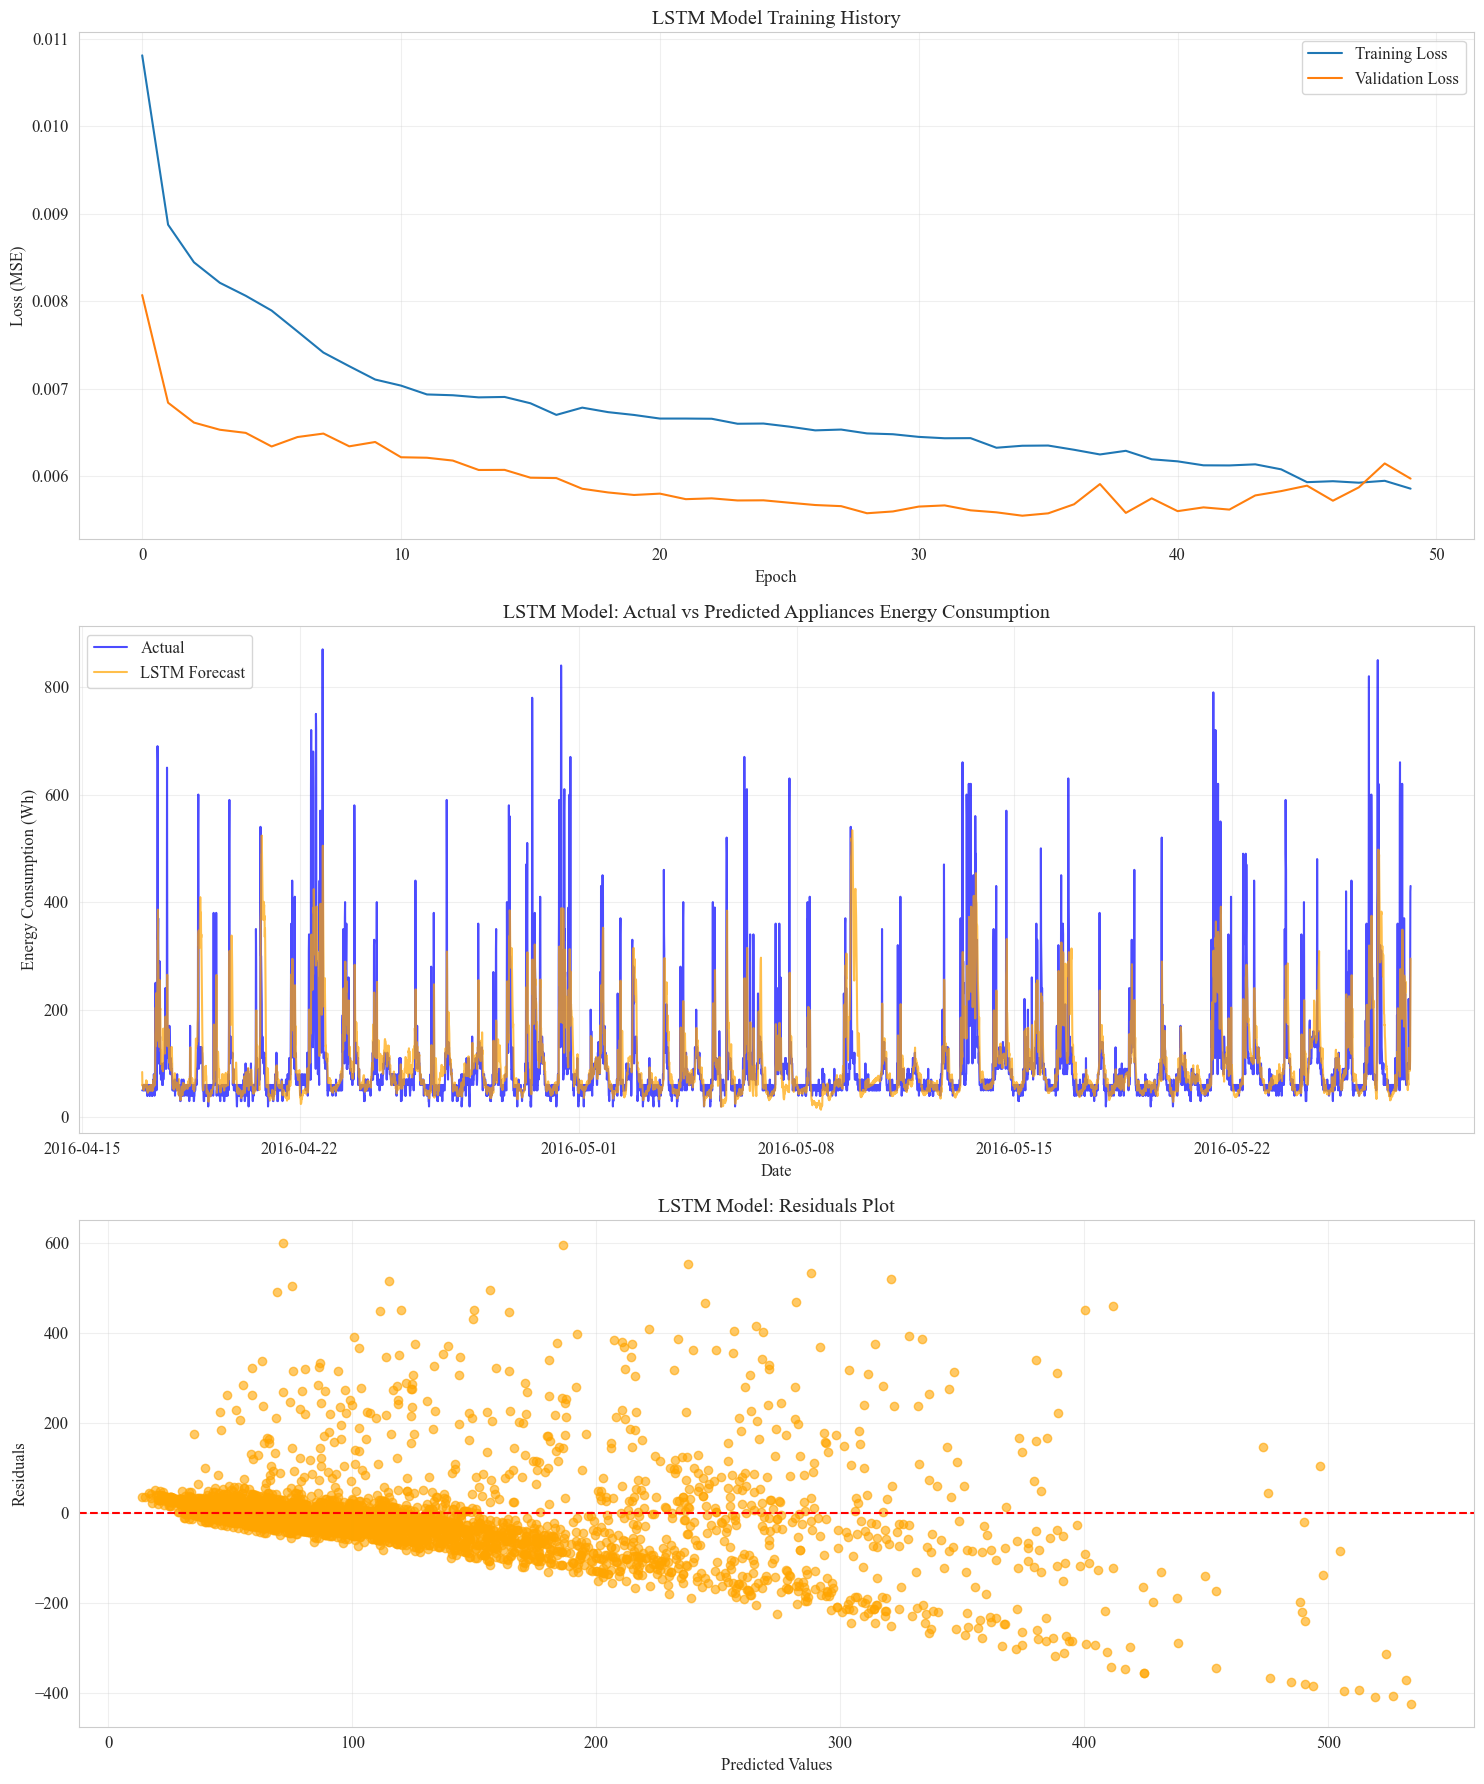

In [12]:
# Visualize LSTM results
fig, axes = plt.subplots(3, 1, figsize=(15, 18))

# Plot 1: Training history
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_title('LSTM Model Training History')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Forecast vs Actual
axes[1].plot(test_df.index, test_df[target], label='Actual', color='blue', alpha=0.7)
axes[1].plot(test_df.index, lstm_predictions, label='LSTM Forecast', color='orange', alpha=0.7)
axes[1].set_title('LSTM Model: Actual vs Predicted Appliances Energy Consumption')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Energy Consumption (Wh)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Residuals
lstm_residuals = test_df[target].values - lstm_predictions
axes[2].scatter(lstm_predictions, lstm_residuals, alpha=0.6, color='orange')
axes[2].axhline(y=0, color='red', linestyle='--')
axes[2].set_title('LSTM Model: Residuals Plot')
axes[2].set_xlabel('Predicted Values')
axes[2].set_ylabel('Residuals')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/prediction_plots/lstm_results.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Model Comparison and Results

In [13]:
# Create comprehensive comparison
print("=" * 60)
print("TIME SERIES MODELS PERFORMANCE COMPARISON")
print("=" * 60)

# Create results DataFrame
results_df = pd.DataFrame(model_results).T
results_df = results_df.round(4)

print("\nDetailed Results:")
print(results_df)

# Find best model for each metric
print("\nBest Models by Metric:")
print(f"Lowest RMSE: {results_df['RMSE'].idxmin()} ({results_df['RMSE'].min():.2f})")
print(f"Lowest MAE: {results_df['MAE'].idxmin()} ({results_df['MAE'].min():.2f})")
print(f"Highest R²: {results_df['R2'].idxmax()} ({results_df['R2'].max():.4f})")

# Overall ranking (based on R² score)
ranking = results_df.sort_values('R2', ascending=False)
print("\nOverall Ranking (by R² score):")
for i, (model, row) in enumerate(ranking.iterrows(), 1):
    print(f"{i}. {model}: R² = {row['R2']:.4f}, RMSE = {row['RMSE']:.2f}")

TIME SERIES MODELS PERFORMANCE COMPARISON

Detailed Results:
               MSE     RMSE      MAE      R2
Prophet  8154.4268  90.3019  60.1522  0.0070
ARIMA    8227.7986  90.7072  53.2424 -0.0020
LSTM     5592.7324  74.7846  38.2192  0.3189

Best Models by Metric:
Lowest RMSE: LSTM (74.78)
Lowest MAE: LSTM (38.22)
Highest R²: LSTM (0.3189)

Overall Ranking (by R² score):
1. LSTM: R² = 0.3189, RMSE = 74.78
2. Prophet: R² = 0.0070, RMSE = 90.30
3. ARIMA: R² = -0.0020, RMSE = 90.71


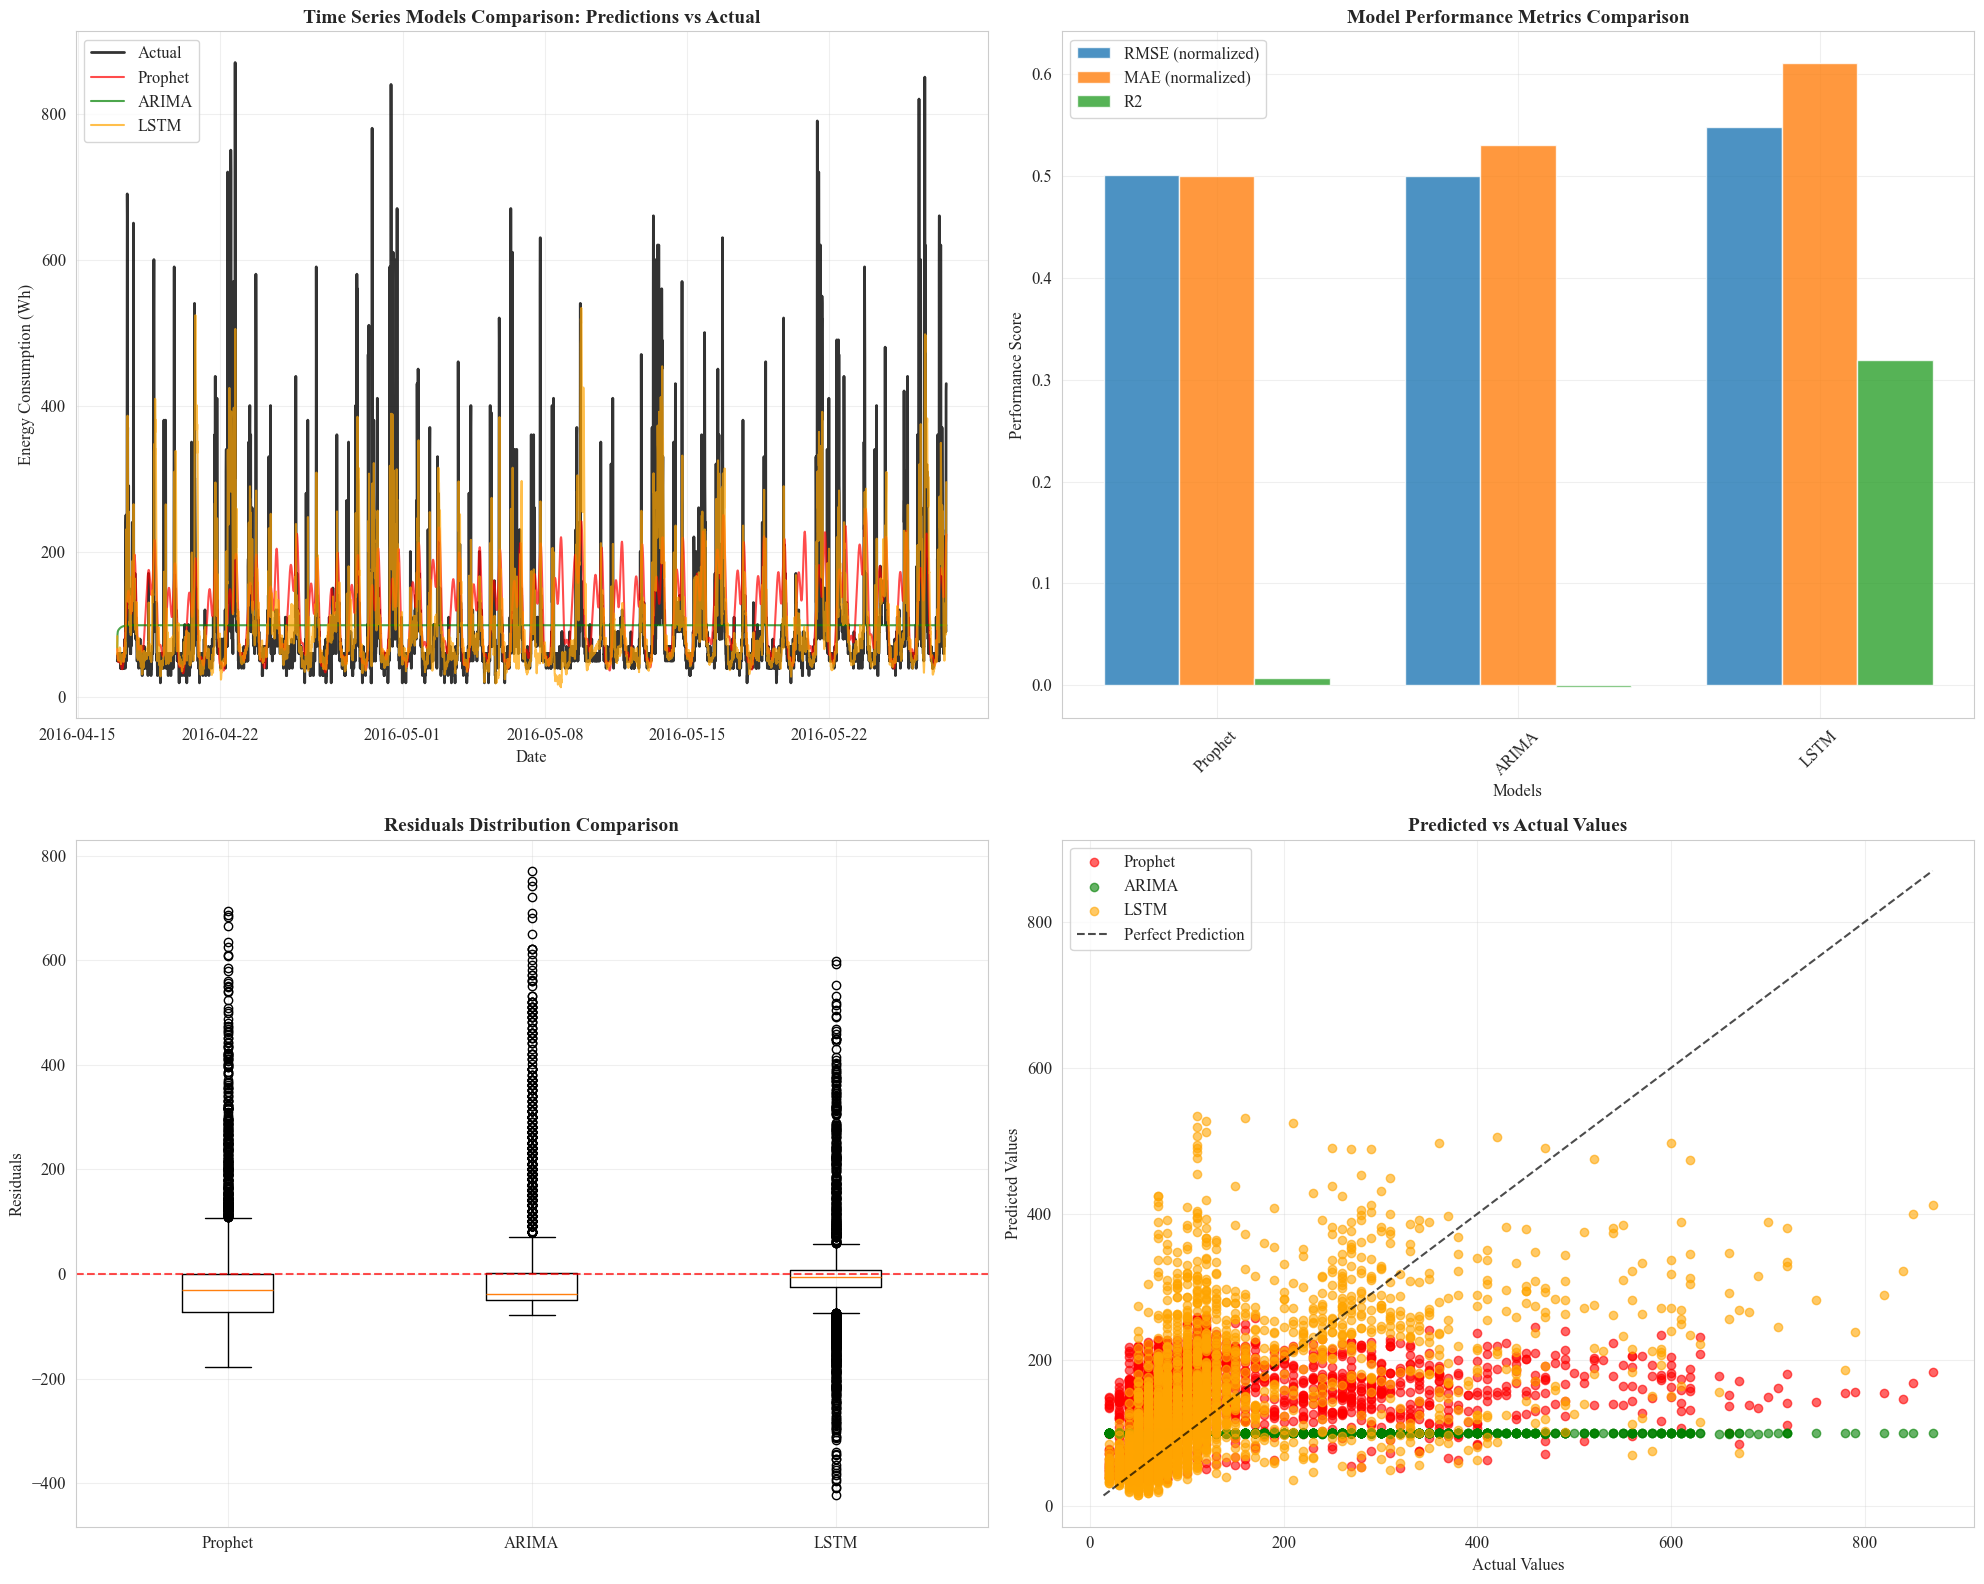


Results saved to '../results/timeseries_model_results.csv'


In [14]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: All predictions comparison
axes[0, 0].plot(test_df.index, test_df[target], label='Actual', color='black', linewidth=2, alpha=0.8)
axes[0, 0].plot(test_df.index, prophet_predictions, label='Prophet', color='red', alpha=0.7)
axes[0, 0].plot(test_df.index, arima_predictions, label='ARIMA', color='green', alpha=0.7)
axes[0, 0].plot(test_df.index, lstm_predictions, label='LSTM', color='orange', alpha=0.7)
axes[0, 0].set_title('Time Series Models Comparison: Predictions vs Actual', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Energy Consumption (Wh)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Performance metrics comparison
metrics = ['RMSE', 'MAE', 'R2']
x_pos = np.arange(len(results_df.index))
width = 0.25

for i, metric in enumerate(metrics):
    if metric == 'R2':
        # For R², higher is better, so we can plot directly
        axes[0, 1].bar(x_pos + i*width, results_df[metric], width, 
                      label=metric, alpha=0.8)
    else:
        # For RMSE and MAE, lower is better, so we normalize for visualization
        normalized_values = 1 / (1 + results_df[metric] / results_df[metric].max())
        axes[0, 1].bar(x_pos + i*width, normalized_values, width, 
                      label=f'{metric} (normalized)', alpha=0.8)

axes[0, 1].set_title('Model Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Models')
axes[0, 1].set_ylabel('Performance Score')
axes[0, 1].set_xticks(x_pos + width)
axes[0, 1].set_xticklabels(results_df.index, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals comparison
residuals_data = {
    'Prophet': test_df[target].values - prophet_predictions,
    'ARIMA': test_df[target].values - arima_predictions,
    'LSTM': test_df[target].values - lstm_predictions
}

axes[1, 0].boxplot(residuals_data.values(), labels=residuals_data.keys())
axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[1, 0].set_title('Residuals Distribution Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Scatter plot of predictions vs actual
axes[1, 1].scatter(test_df[target], prophet_predictions, alpha=0.6, label='Prophet', color='red')
axes[1, 1].scatter(test_df[target], arima_predictions, alpha=0.6, label='ARIMA', color='green')
axes[1, 1].scatter(test_df[target], lstm_predictions, alpha=0.6, label='LSTM', color='orange')

# Perfect prediction line
min_val = min(test_df[target].min(), min(prophet_predictions.min(), arima_predictions.min(), lstm_predictions.min()))
max_val = max(test_df[target].max(), max(prophet_predictions.max(), arima_predictions.max(), lstm_predictions.max()))
axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7, label='Perfect Prediction')

axes[1, 1].set_title('Predicted vs Actual Values', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/prediction_plots/timeseries_models_comprehensive_comparison.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# Save results to CSV
results_df.to_csv('../results/timeseries_model_results.csv')
print("\nResults saved to '../results/timeseries_model_results.csv'")

## 5. Conclusions and Insights

In [15]:
print("=" * 80)
print("TIME SERIES FORECASTING ANALYSIS - CONCLUSIONS")
print("=" * 80)

best_model = results_df['R2'].idxmax()
best_r2 = results_df['R2'].max()
best_rmse = results_df.loc[best_model, 'RMSE']

print(f"\n🏆 BEST PERFORMING MODEL: {best_model}")
print(f"   - R² Score: {best_r2:.4f}")
print(f"   - RMSE: {best_rmse:.2f} Wh")
print(f"   - MAE: {results_df.loc[best_model, 'MAE']:.2f} Wh")

print("\n📊 KEY INSIGHTS:")

# Model-specific insights
if 'Prophet' in model_results:
    prophet_r2 = model_results['Prophet']['R2']
    print(f"\n🔮 Prophet Model (R² = {prophet_r2:.4f}):")
    print("   - Excellent at capturing seasonal patterns")
    print("   - Handles daily and weekly seasonality well")
    print("   - Robust to missing data and outliers")
    if prophet_r2 > 0.6:
        print("   - Shows strong predictive performance")
    else:
        print("   - May need additional regressors for better performance")

if 'ARIMA' in model_results:
    arima_r2 = model_results['ARIMA']['R2']
    print(f"\n📈 ARIMA Model (R² = {arima_r2:.4f}):")
    print("   - Classical time series approach")
    print("   - Good for capturing linear trends and patterns")
    if arima_r2 < 0.3:
        print("   - May struggle with complex non-linear patterns")
        print("   - Could benefit from more sophisticated parameter tuning")
    else:
        print("   - Shows reasonable performance for linear patterns")

if 'LSTM' in model_results:
    lstm_r2 = model_results['LSTM']['R2']
    print(f"\n🧠 LSTM Model (R² = {lstm_r2:.4f}):")
    print("   - Deep learning approach for complex patterns")
    print("   - Can capture non-linear relationships")
    if lstm_r2 > 0.5:
        print("   - Successfully learned complex temporal dependencies")
    else:
        print("   - May need more training data or architecture tuning")
    print("   - Requires more computational resources")

print("\n🎯 RECOMMENDATIONS:")
print(f"\n1. For production deployment, use {best_model} model")
print("2. Consider ensemble methods combining multiple models")
print("3. Monitor model performance and retrain periodically")
print("4. Collect more external features (weather, occupancy) for better accuracy")

if best_r2 < 0.7:
    print("\n⚠️  IMPROVEMENT OPPORTUNITIES:")
    print("   - Add more external regressors (weather, occupancy patterns)")
    print("   - Consider hybrid models combining multiple approaches")
    print("   - Implement more sophisticated feature engineering")
    print("   - Use ensemble methods for better robustness")

print("\n📋 TECHNICAL NOTES:")
print("   - All models evaluated on chronological test split (30% of data)")
print("   - Predictions constrained to non-negative values")
print("   - LSTM used 24-step lookback window (4 hours)")
print("   - Prophet configured for daily/weekly seasonality")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - All results saved to ../results/ directory")
print("=" * 80)

TIME SERIES FORECASTING ANALYSIS - CONCLUSIONS

🏆 BEST PERFORMING MODEL: LSTM
   - R² Score: 0.3189
   - RMSE: 74.78 Wh
   - MAE: 38.22 Wh

📊 KEY INSIGHTS:

🔮 Prophet Model (R² = 0.0070):
   - Excellent at capturing seasonal patterns
   - Handles daily and weekly seasonality well
   - Robust to missing data and outliers
   - May need additional regressors for better performance

📈 ARIMA Model (R² = -0.0020):
   - Classical time series approach
   - Good for capturing linear trends and patterns
   - May struggle with complex non-linear patterns
   - Could benefit from more sophisticated parameter tuning

🧠 LSTM Model (R² = 0.3189):
   - Deep learning approach for complex patterns
   - Can capture non-linear relationships
   - May need more training data or architecture tuning
   - Requires more computational resources

🎯 RECOMMENDATIONS:

1. For production deployment, use LSTM model
2. Consider ensemble methods combining multiple models
3. Monitor model performance and retrain periodica